# Takes tables with VCF data on the variants of two levels and plots them to the protein sequence for each isoform

In [1]:
import pandas as pd
from pyteomics import fasta
from numpy import nan

import matplotlib.colors as mcolors
from matplotlib import pyplot as plt, patches
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec

## 1. Table with all the variants ('level 1 table')

Creating a table that contains transcript and protein IDs along with gene names, protein sequences (unmodified) and protein descriptions taken from FASTA. For these purpose canonical proteome fasta with all isoforms downloaded from Ensembl is used. 

Also creating an 'info' table that contains the number of transcripts and the number of variants belonging to each gene name. This is useful to have in ordet to estimete how each plot will look like in the end. 

In [ ]:
table = pd.read_table(
    'results/MD_var_level1_unfiltered.tsv')
table = table.rename(columns={"transcriptID": "transcript_id"})
transcripts = table['transcript_id'].tolist()

data_names = []
with fasta.read(
    'input/ensembl_reference_proteinDB_tagged.fa') as f:
    for prot in f:
        transcript_ID = prot.description.split('transcript:')[1].split('.')[0]
        proteinID = prot.description.replace('.', '|').split('|')[1]
        for item in transcripts:
            if item == transcript_ID:
                if 'gene_symbol:' in prot.description:
                    gene_name = prot.description.split('gene_symbol:')[1].split(' ')[0]
                    data_names.append({'transcript_id': transcript_ID, 
                                       'gene_name': gene_name, 
                                       'description': prot.description,
                                       'unmodified_sequence': prot.sequence,
                                       'protein_id': proteinID})
                        
                        
name_frame = pd.DataFrame(data_names).drop_duplicates().reset_index(drop=True)
table_names = pd.merge(table, name_frame, how='outer', on = 'transcript_id').replace(nan, '')
var_gene_names = table_names[table_names['gene_name'] != ''].reset_index(drop=True)

#######
info = []
genes = var_gene_names['gene_name'].unique()
for gene in genes:
    info.append({'gene': gene, 'transcripts': 
                 len(var_gene_names[var_gene_names['gene_name'] == gene]['transcript_id'].unique()), 'variants':
                 len(var_gene_names[var_gene_names['gene_name'] == gene]['protein_change'].unique())})
info_df = pd.DataFrame(info)
info_df.to_csv(
    'intermediate/info_level1_prot.csv',
    header=True, index=False)
#######

var_gene_names.to_csv(
    'intermediate/all_variants_gene_names_prot_level1.csv',
    header=True, index=False)


In [ ]:
var_gene_names

In [ ]:
var_gene_names[var_gene_names['reading_frame'] == -1]

In [ ]:
info_df

## 2. The same for the 'level 2' more confident filtered variants

In [ ]:
table2 = pd.read_table('results/MD_var_level2_unfiltered.tsv')
table2 = table2.rename(columns={"transcriptID": "transcript_id"})
transcripts2 = table2['transcript_id'].tolist()


data_names2 = []
with fasta.read('input/ensembl_reference_proteinDB_tagged.fa') as f:
    for prot in f:
        transcript_ID = prot.description.split('transcript:')[1].split('.')[0]
        proteinID = prot.description.replace('.', '|').split('|')[1]
        for item in transcripts2:
            if item == transcript_ID:
                if 'gene_symbol:' in prot.description:
                    gene_name = prot.description.split('gene_symbol:')[1].split(' ')[0]
                    data_names2.append({'transcript_id': transcript_ID, 
                                       'gene_name': gene_name, 
                                       'description': prot.description,
                                       'unmodified_sequence': prot.sequence, 
                                       'protein_id': proteinID})
                        
                        
name_frame2 = pd.DataFrame(data_names2).drop_duplicates().reset_index(drop=True)
table_names2 = pd.merge(table2, name_frame2, how='outer', on = 'transcript_id').replace(nan, '')
var_gene_names2 = table_names2[table_names2['gene_name'] != ''].reset_index(drop=True)

#######
info2 = []
genes2 = var_gene_names['gene_name'].unique()
for gene in genes2:
    info2.append({'gene': gene, 'transcripts': 
                 len(var_gene_names[var_gene_names['gene_name'] == gene]['transcript_id'].unique()), 'variants':
                 len(var_gene_names[var_gene_names['gene_name'] == gene]['protein_change'].unique())})
info_df2 = pd.DataFrame(info2)
info_df2.to_csv('intermediate/info_level2_prot.csv', header=True, index=False)
#######

var_gene_names2.to_csv('intermediate/all_variants_gene_names_prot_level2.csv', header=True, index=False)


## 3. Plotting data from two tables in one plot

In [3]:
# Genes present in both levels
genes = var_gene_names2['gene_name'].unique()
genes

array(['GPR161', 'KLF11', 'EIF2AK3', 'SCN1A', 'NEUROD1', 'APPL1',
       'SLC2A2', 'PURA', 'ZFP57', 'RFX6', 'GCK', 'PAX4', 'LEP', 'BLK',
       'GLIS3', 'CEL', 'PTF1A', 'INS-IGF2', 'INS', 'KCNQ1', 'KCNJ11',
       'ABCC8', 'PAX6', 'HNF1A', 'C12orf43', 'PDX1', 'TRIP11', 'MAGEL2',
       'FBN1', 'MLKL', 'HNF1B', 'HNF4A', 'KCNQ2', 'LZTR1', 'SHANK3',
       'FOXP3'], dtype=object)

KLF11
EIF2AK3
NEUROD1
SLC2A2
ZFP57
RFX6
GCK
PAX4
BLK
GLIS3
CEL
PTF1A
INS-IGF2
INS
KCNJ11
ABCC8
PAX6
HNF1A
C12orf43
PDX1


/var/folders/l9/8pj0s89x2533vw_6wcn7h2tm0000gn/T/ipykernel_7758/1868799724.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(55, (number_of_transcr * 2 - 1)), constrained_layout=True)


HNF1B
HNF4A
FOXP3


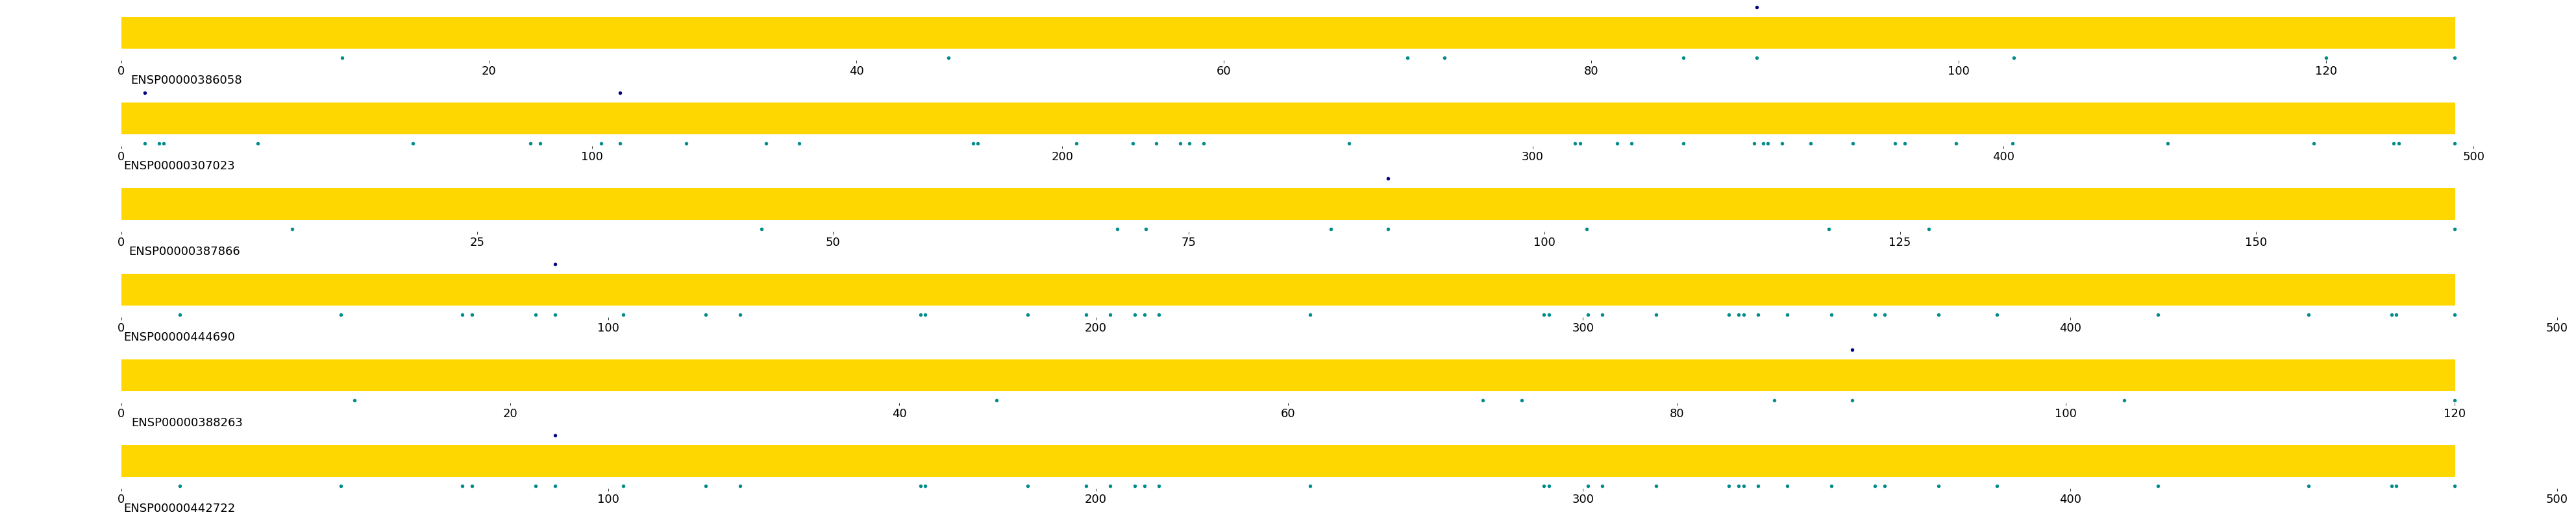

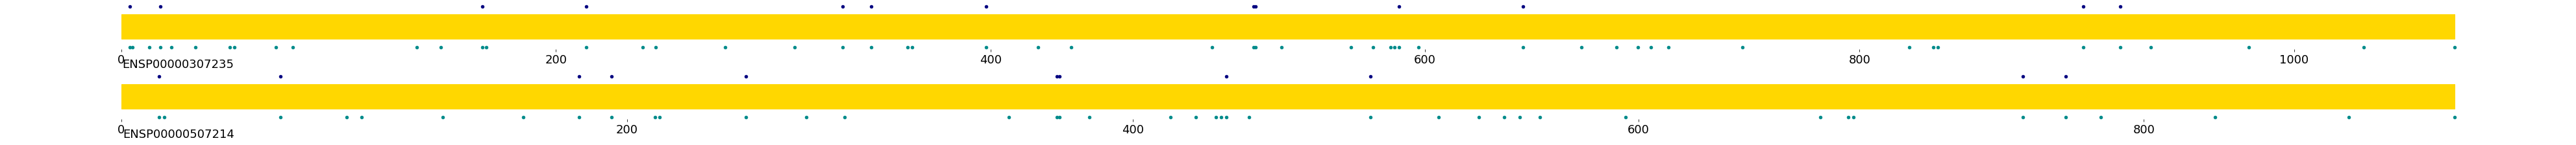

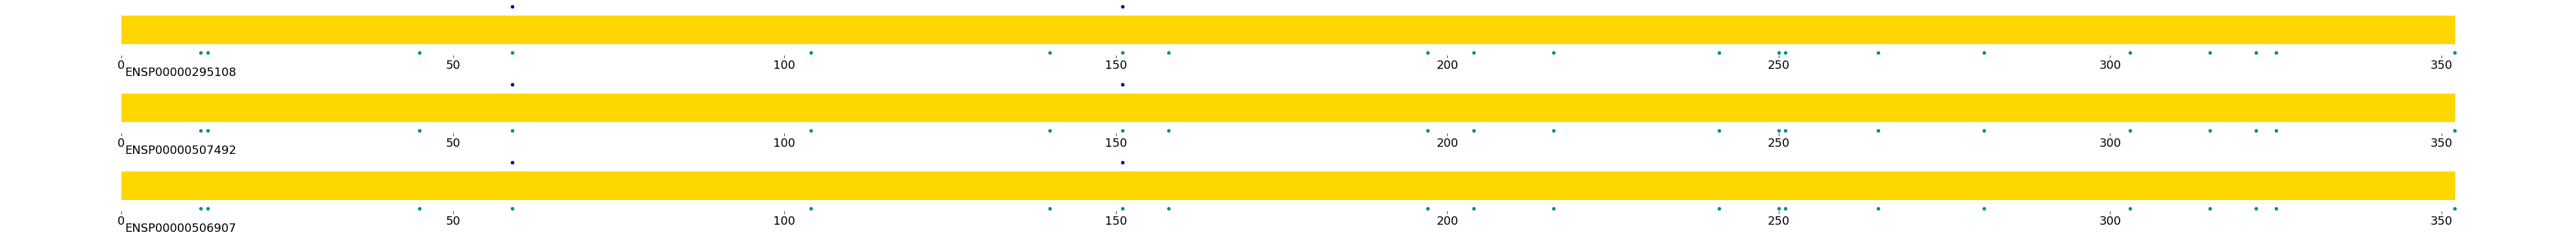

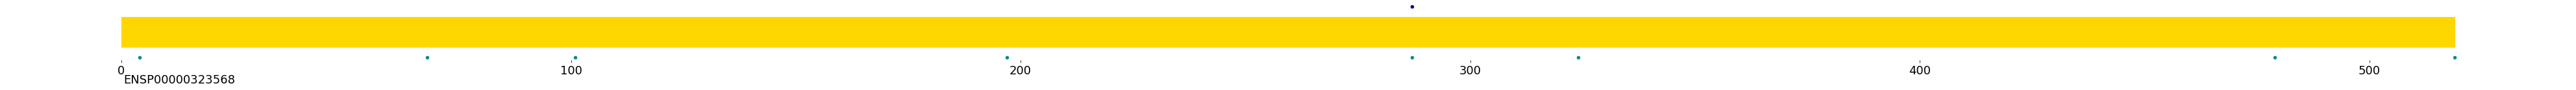

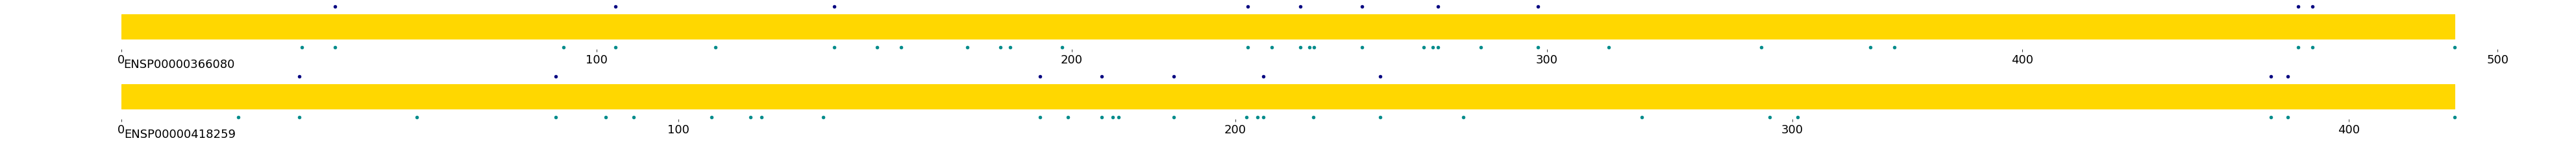

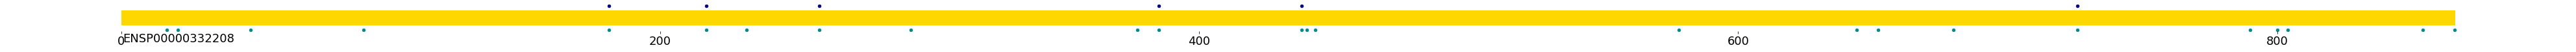

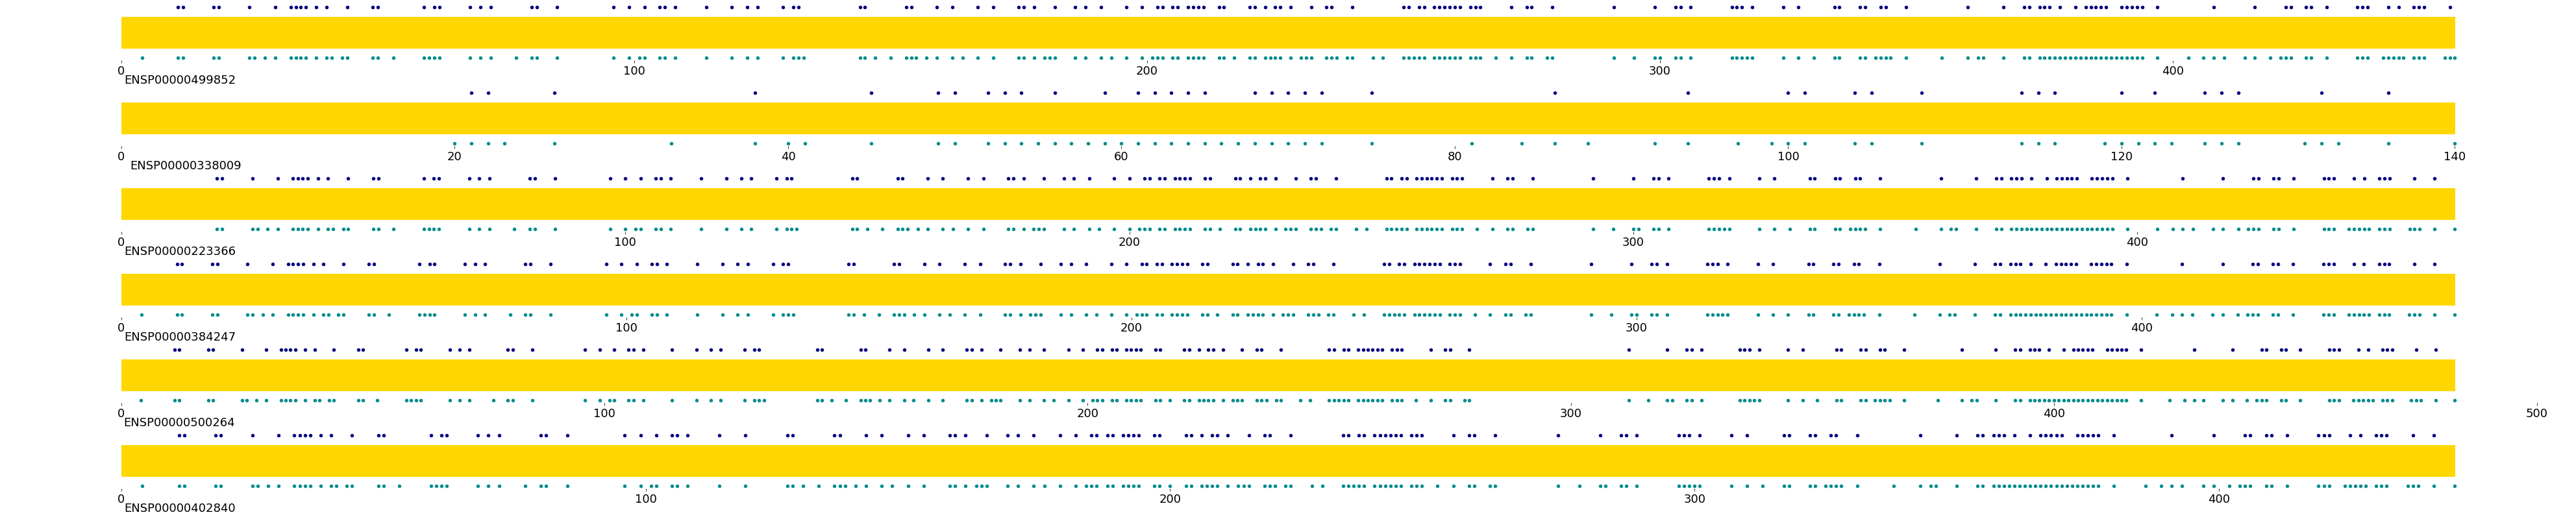

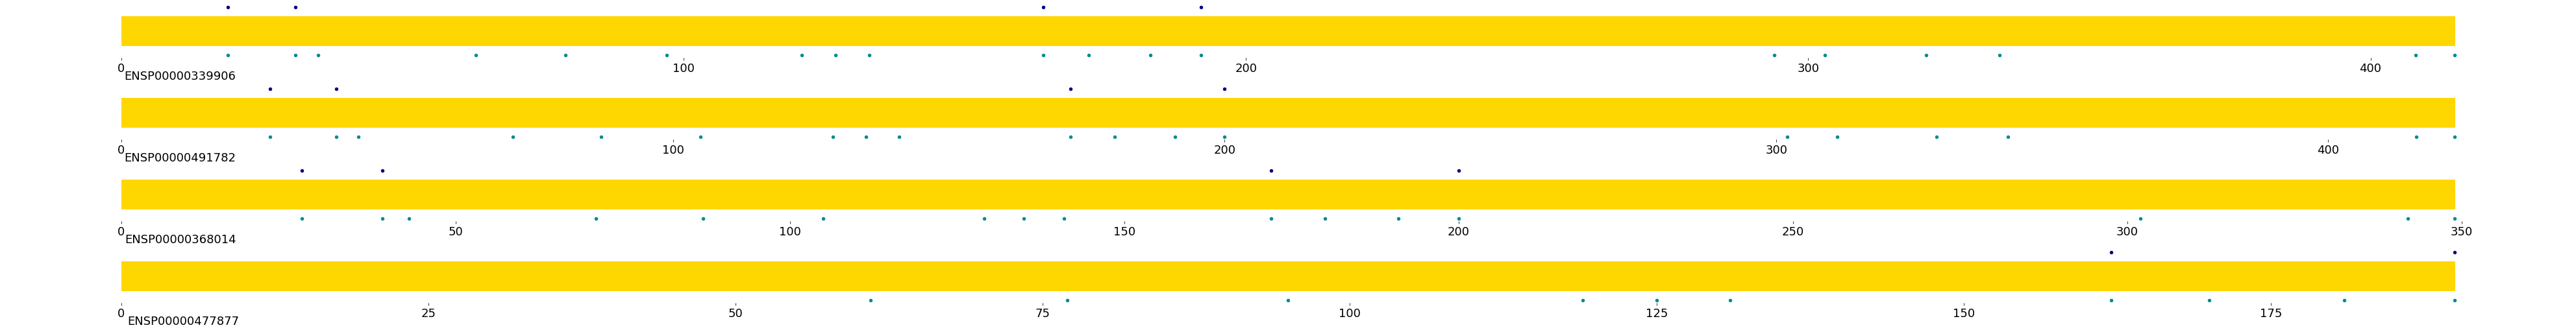

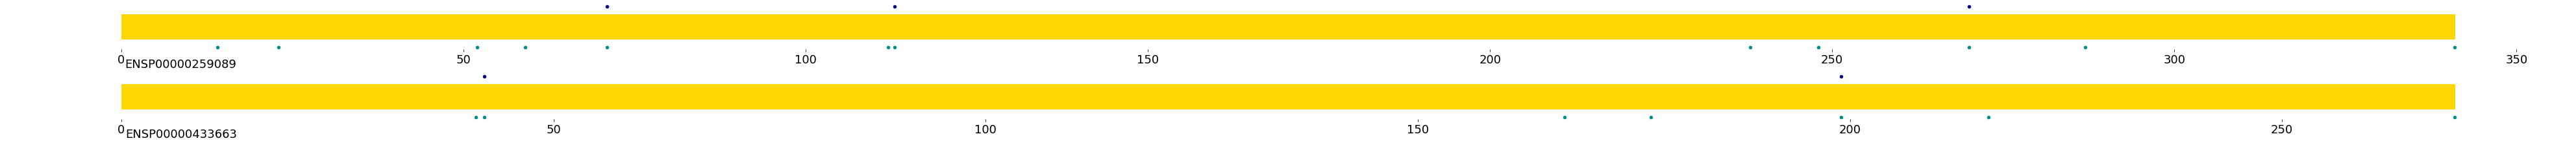

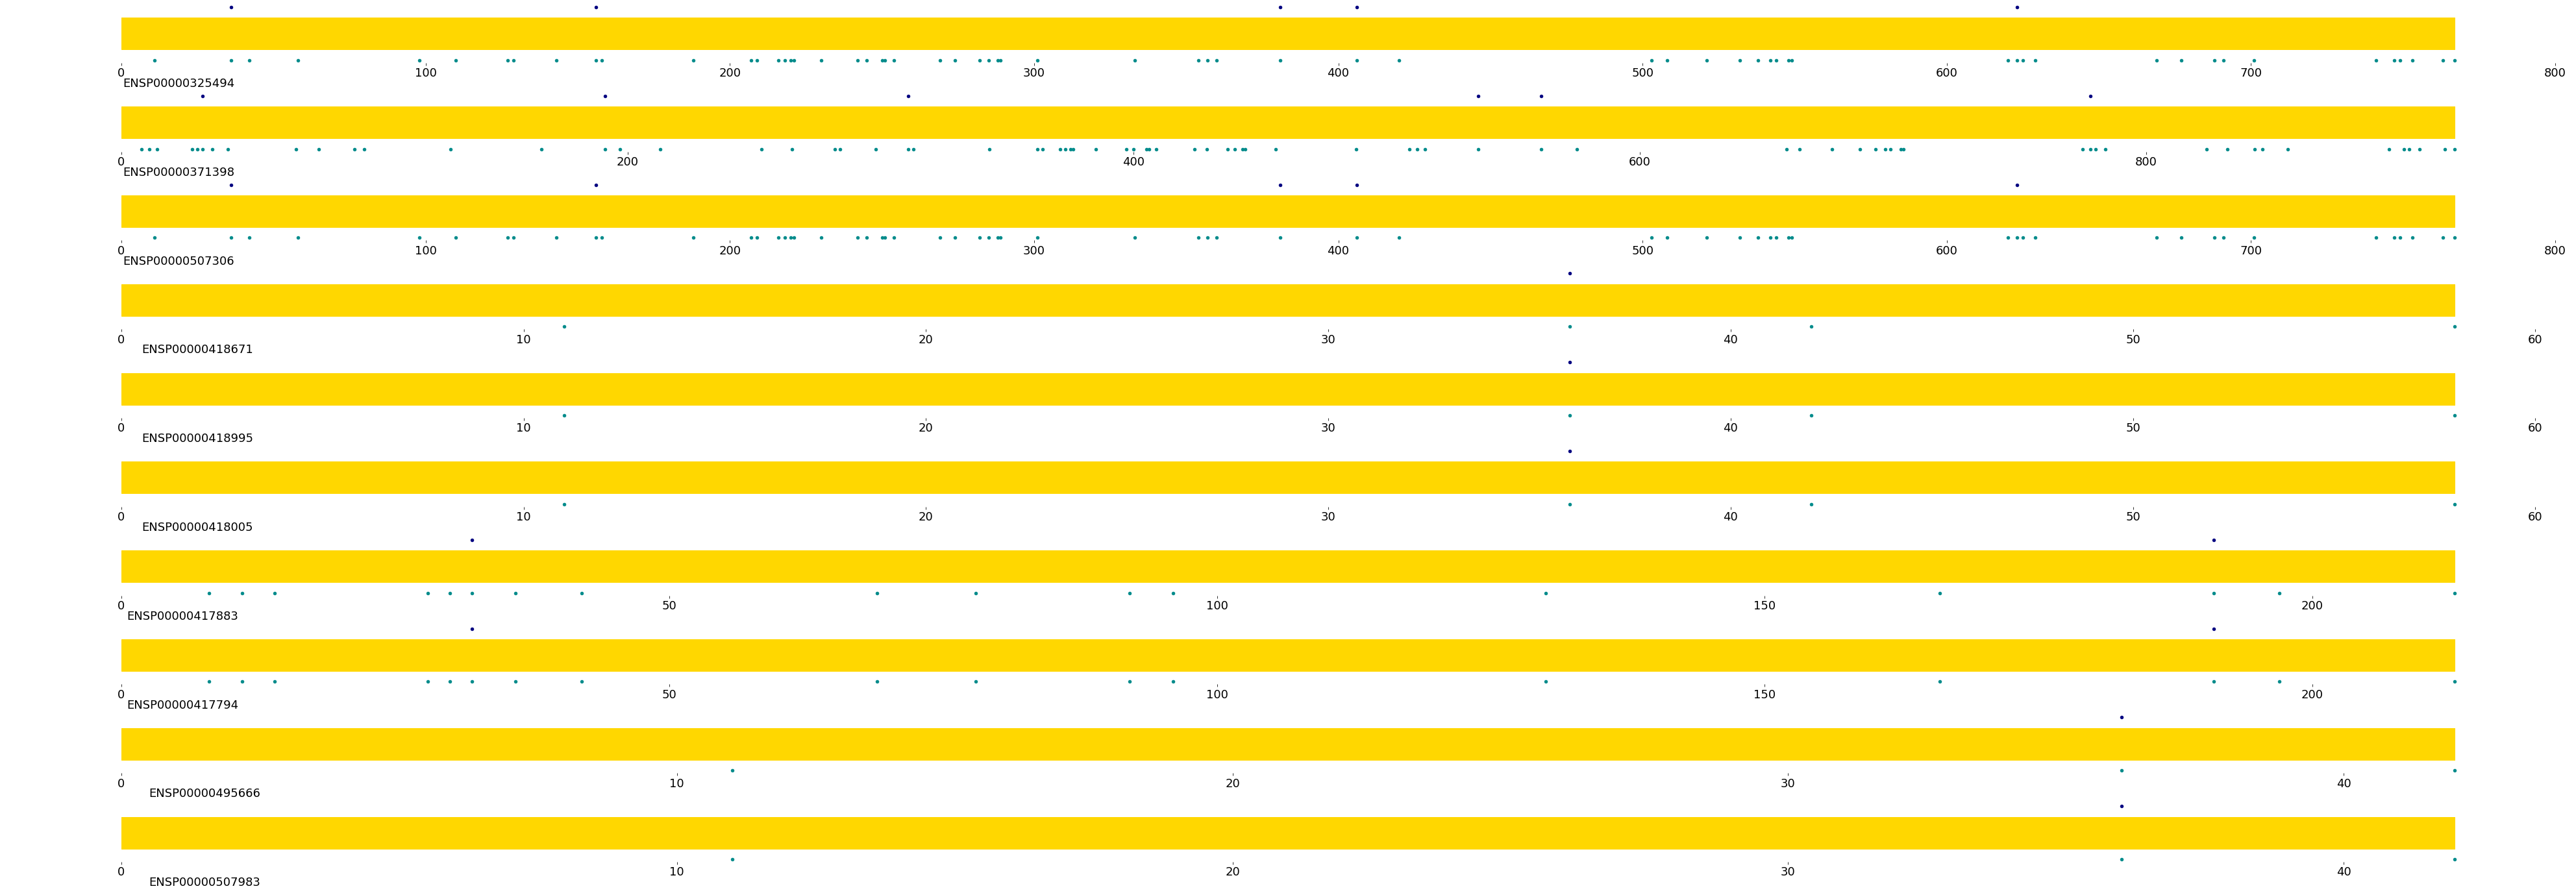

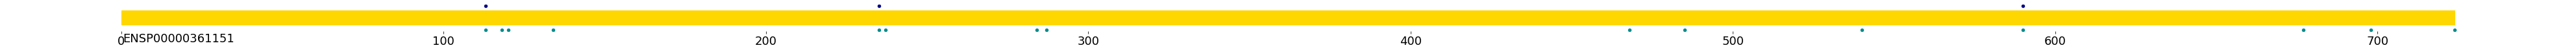

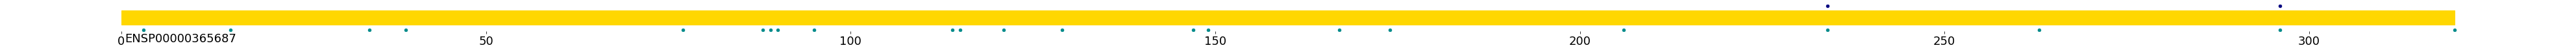

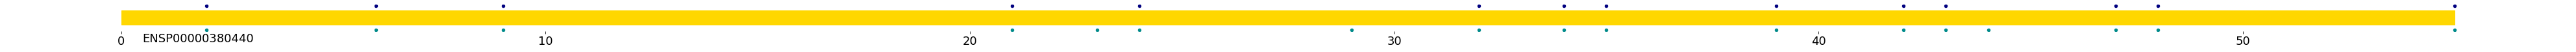

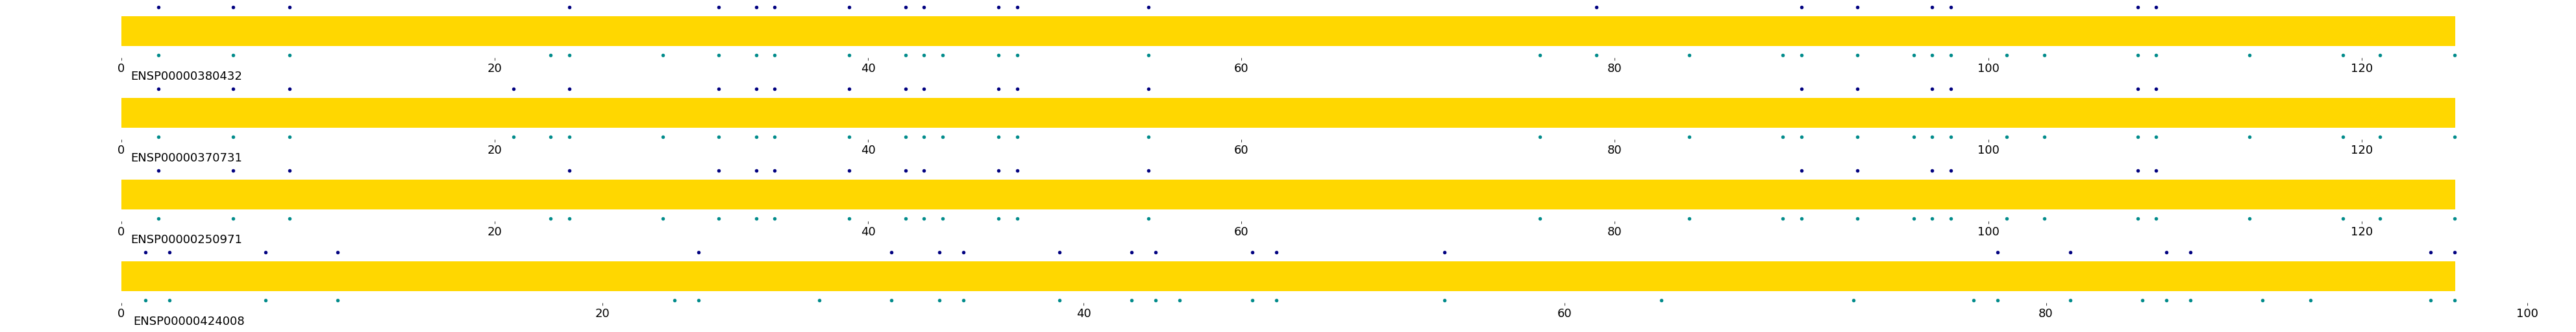

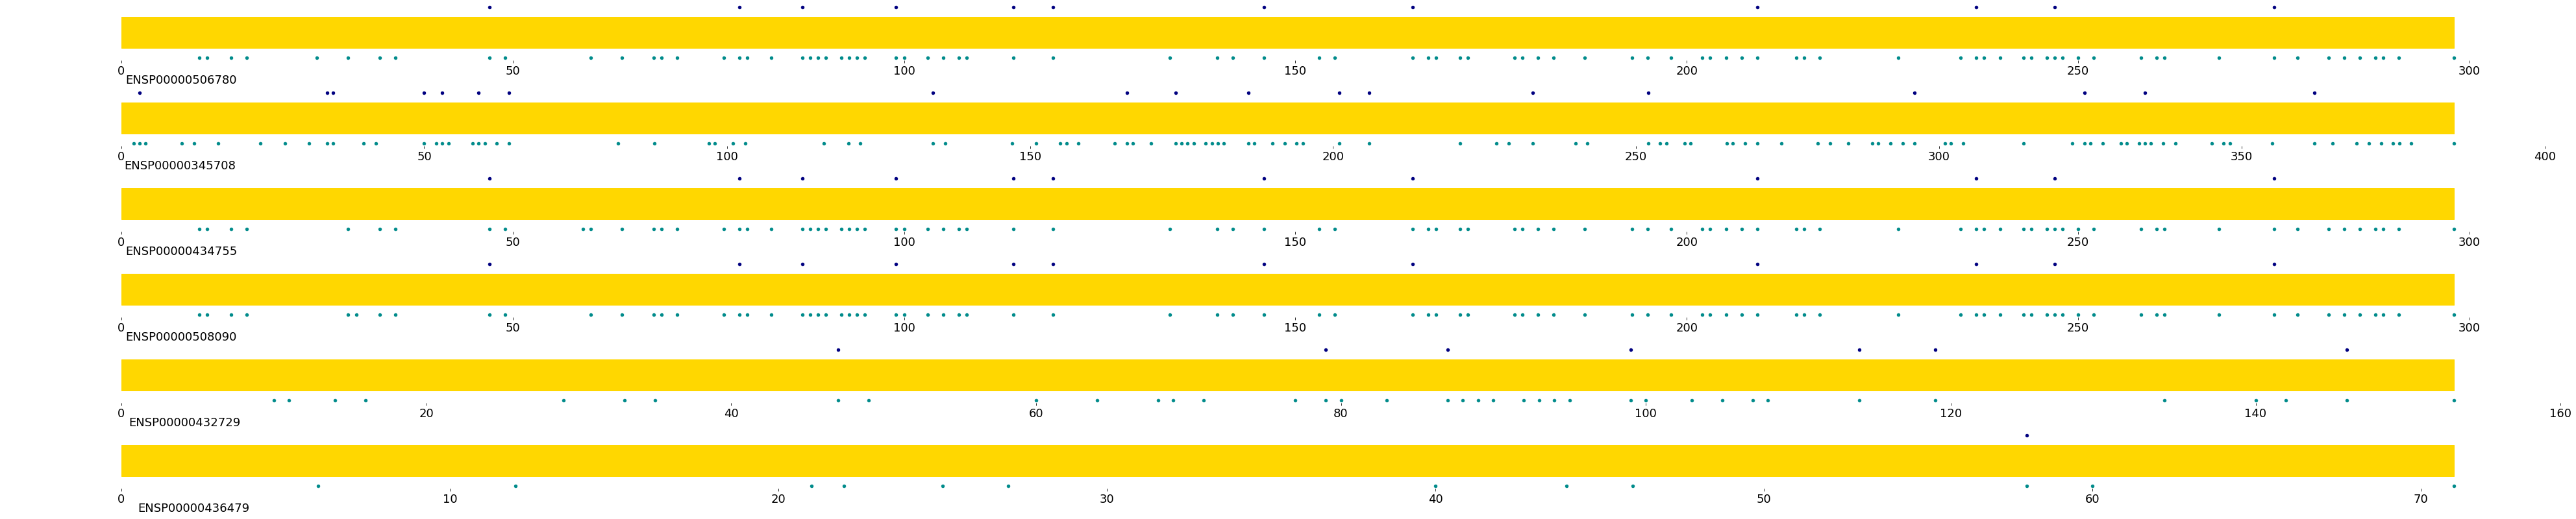

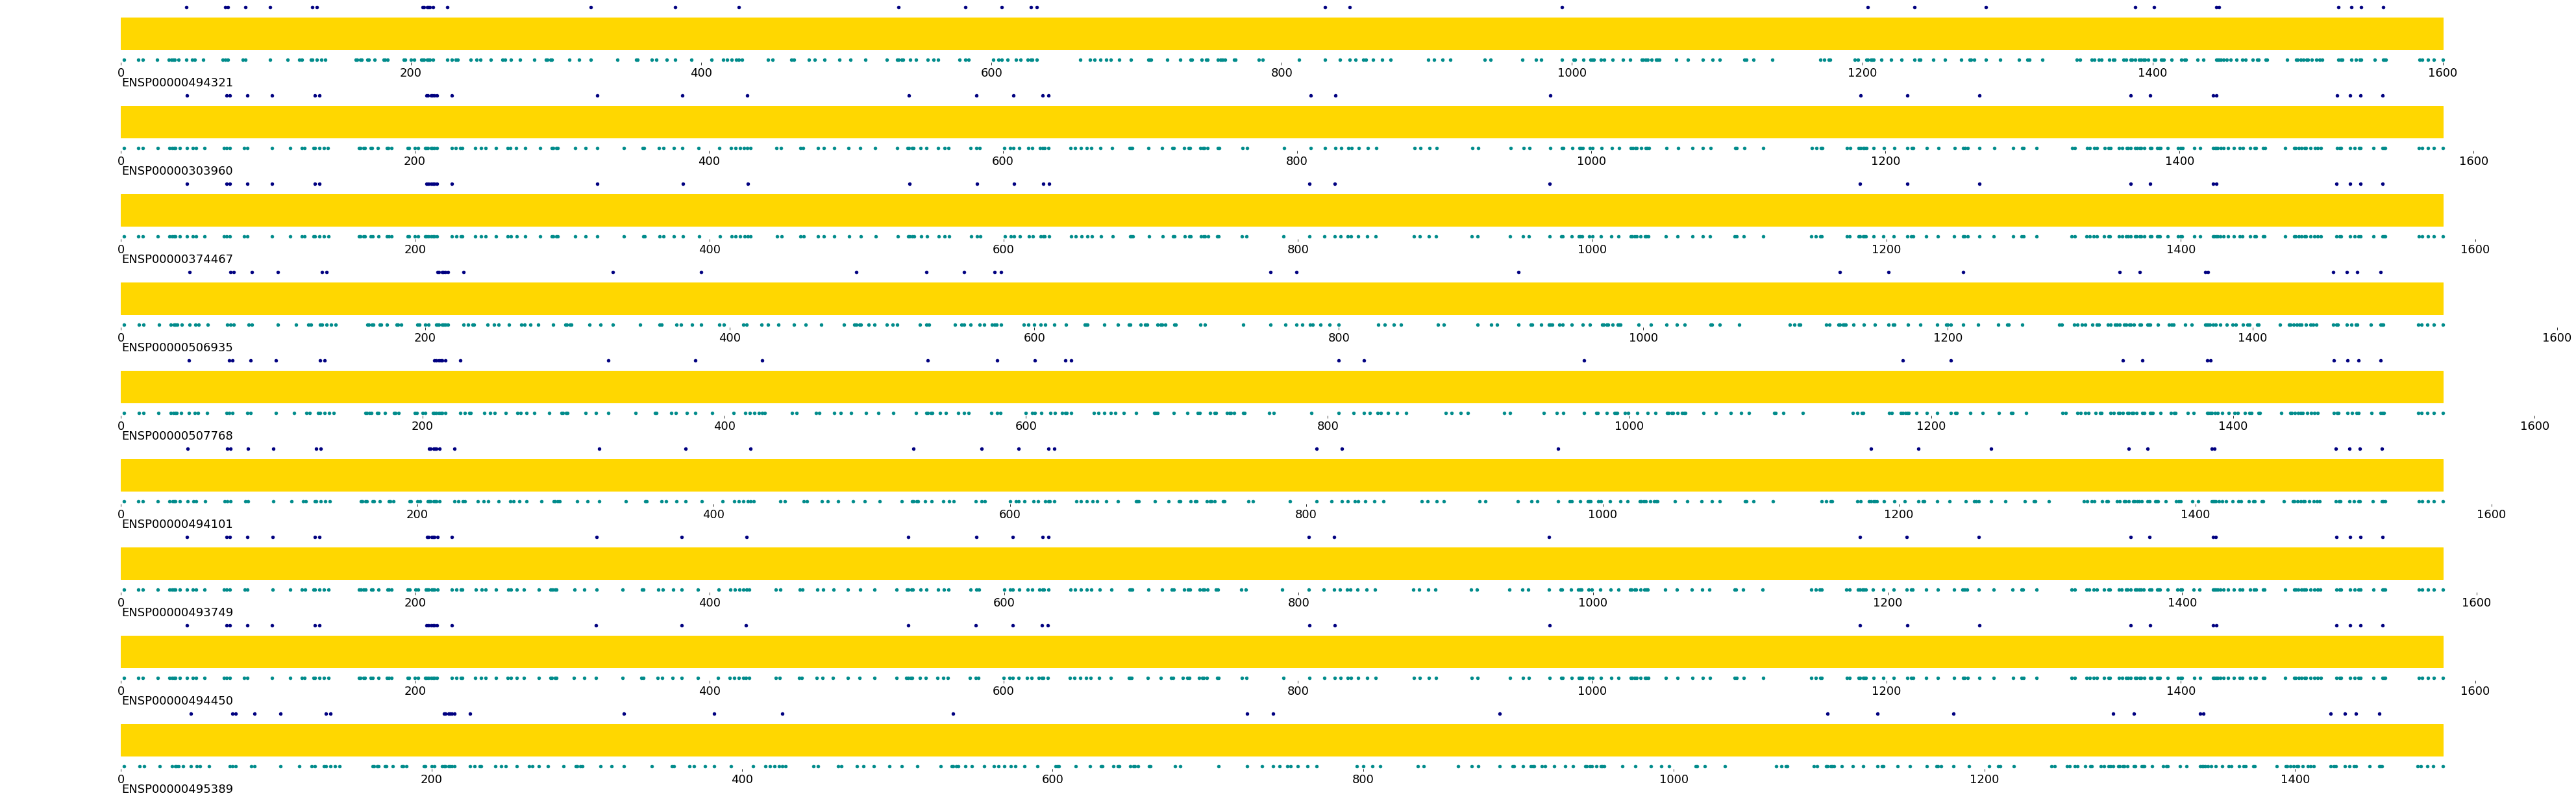

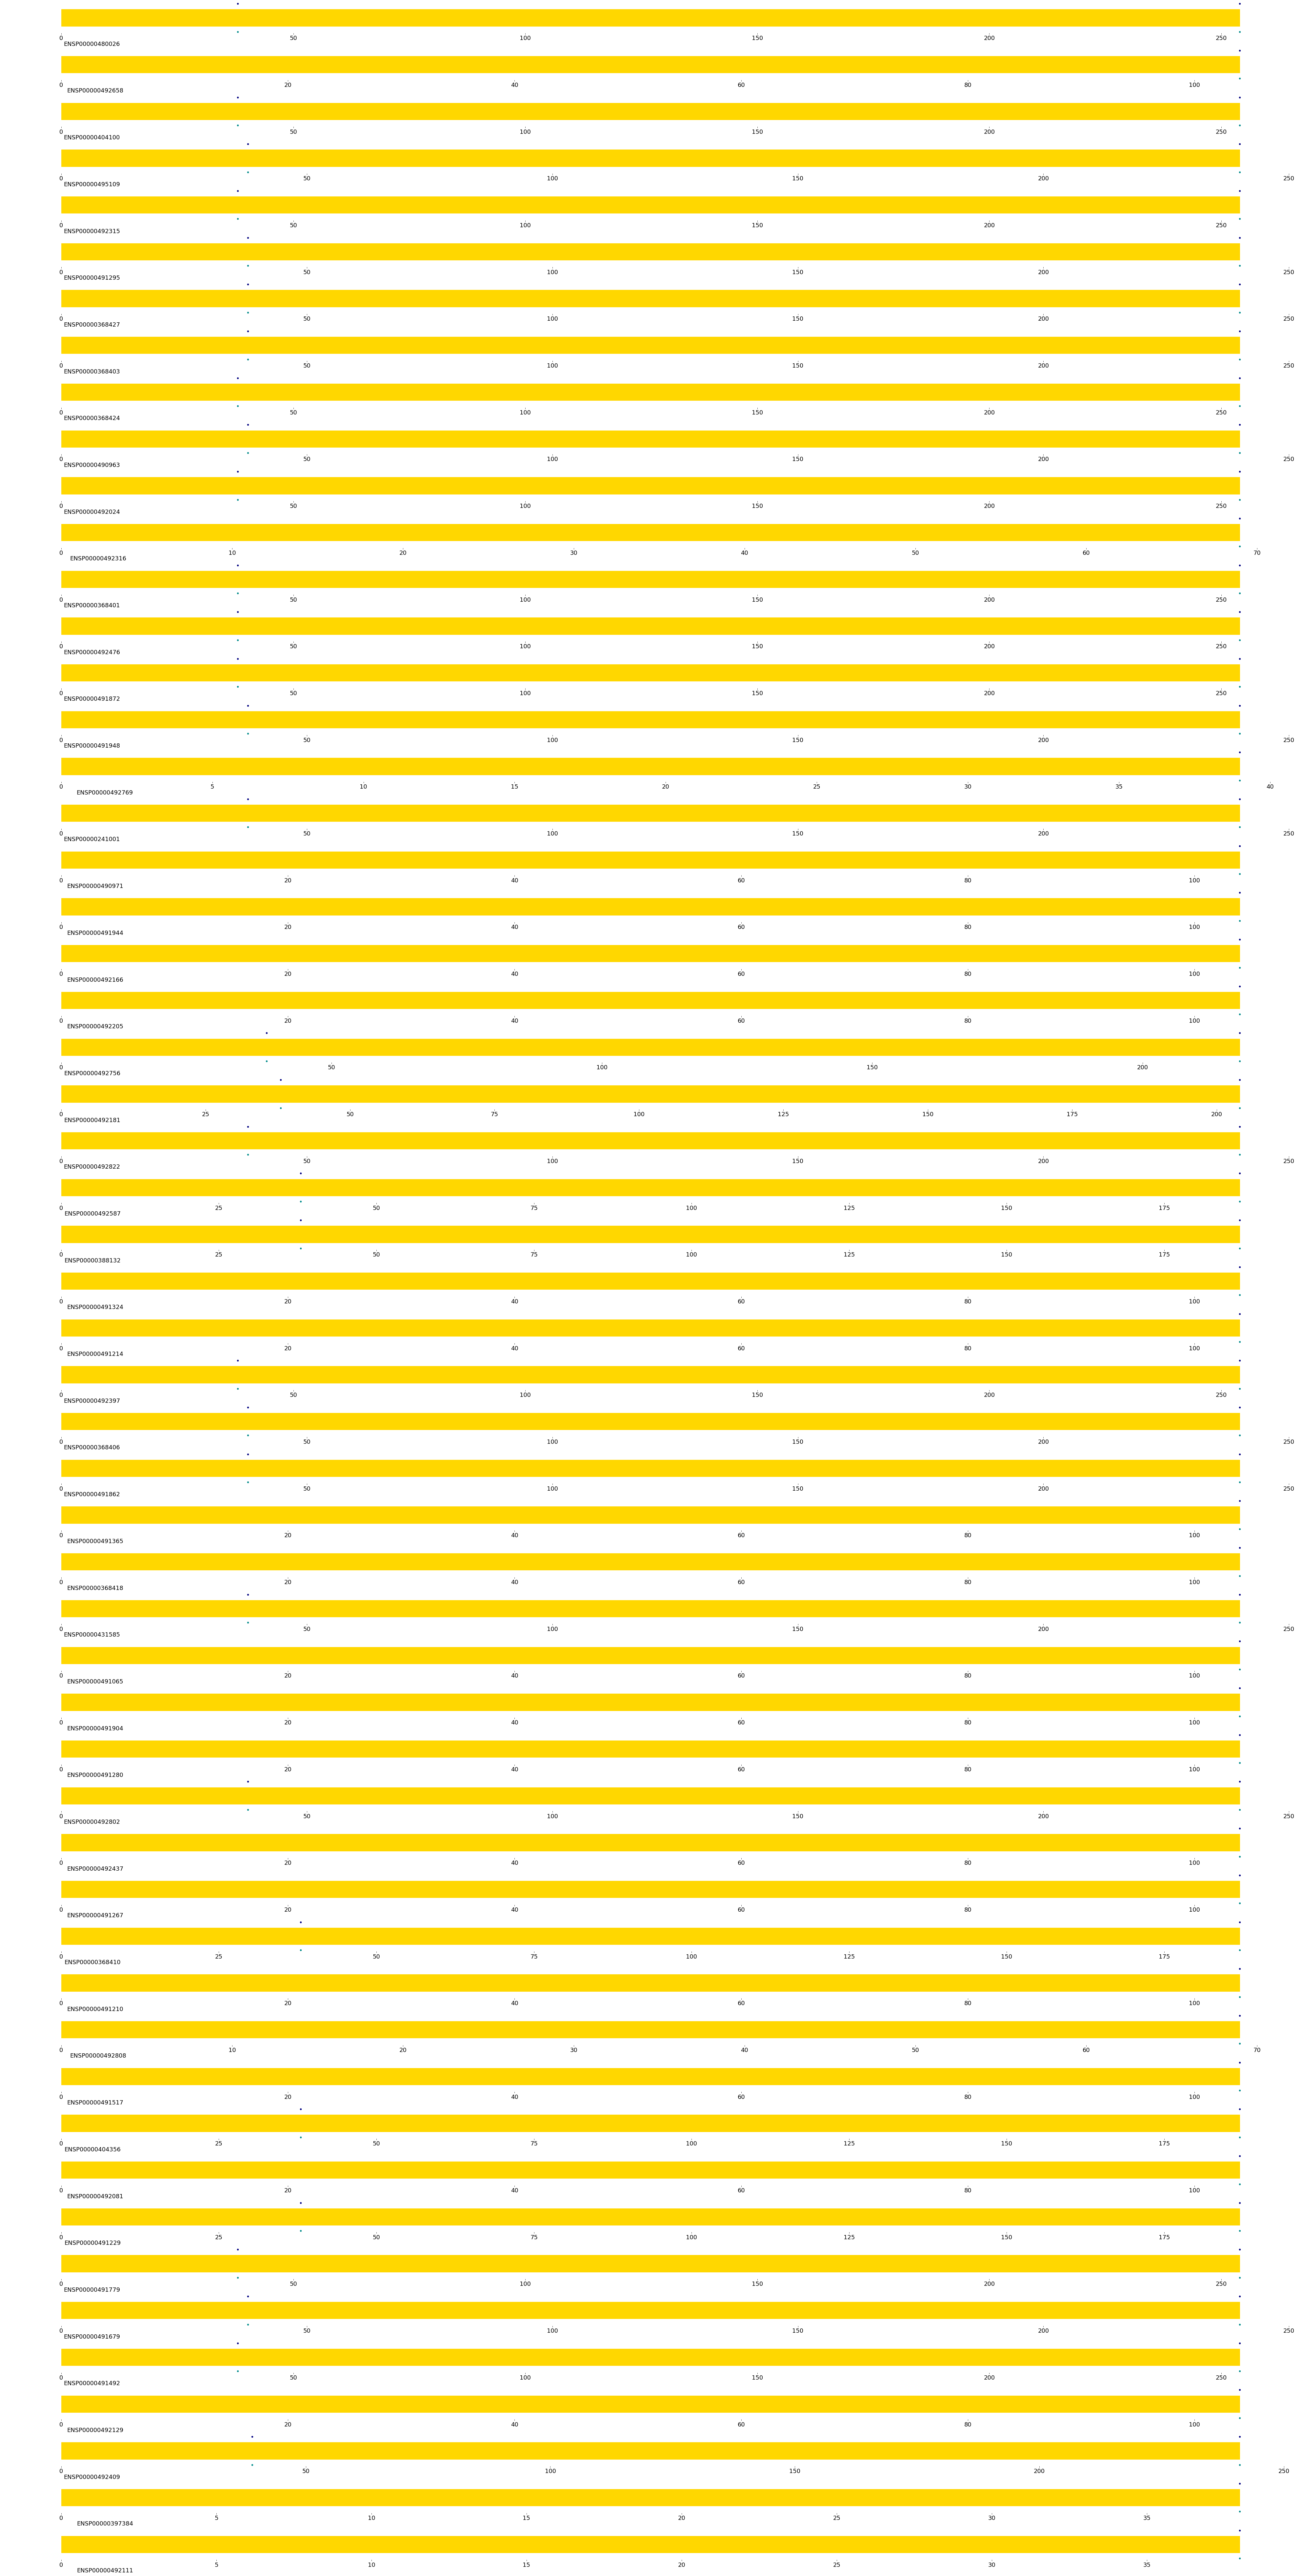

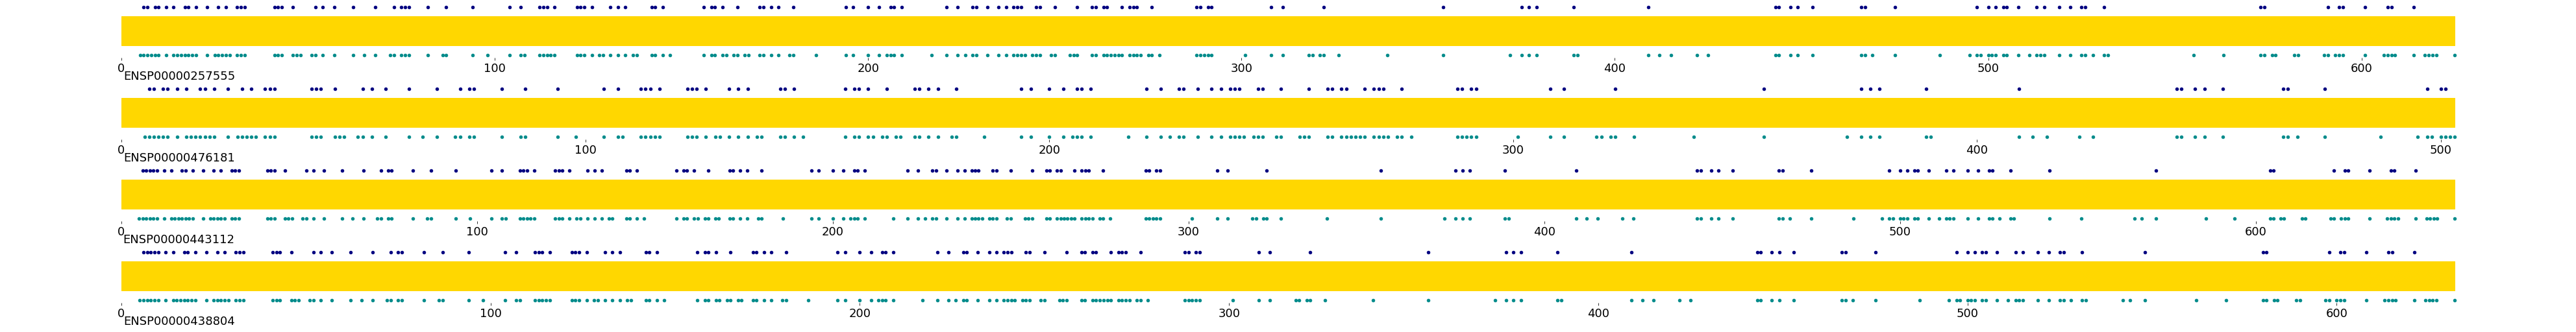

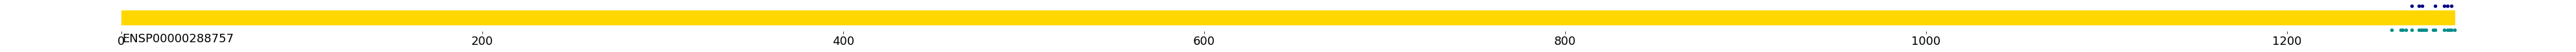

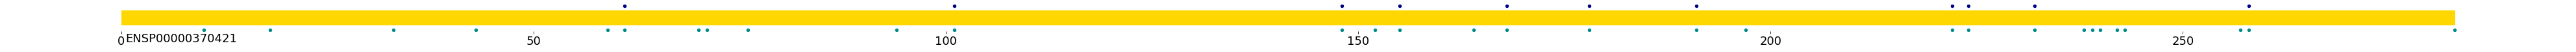

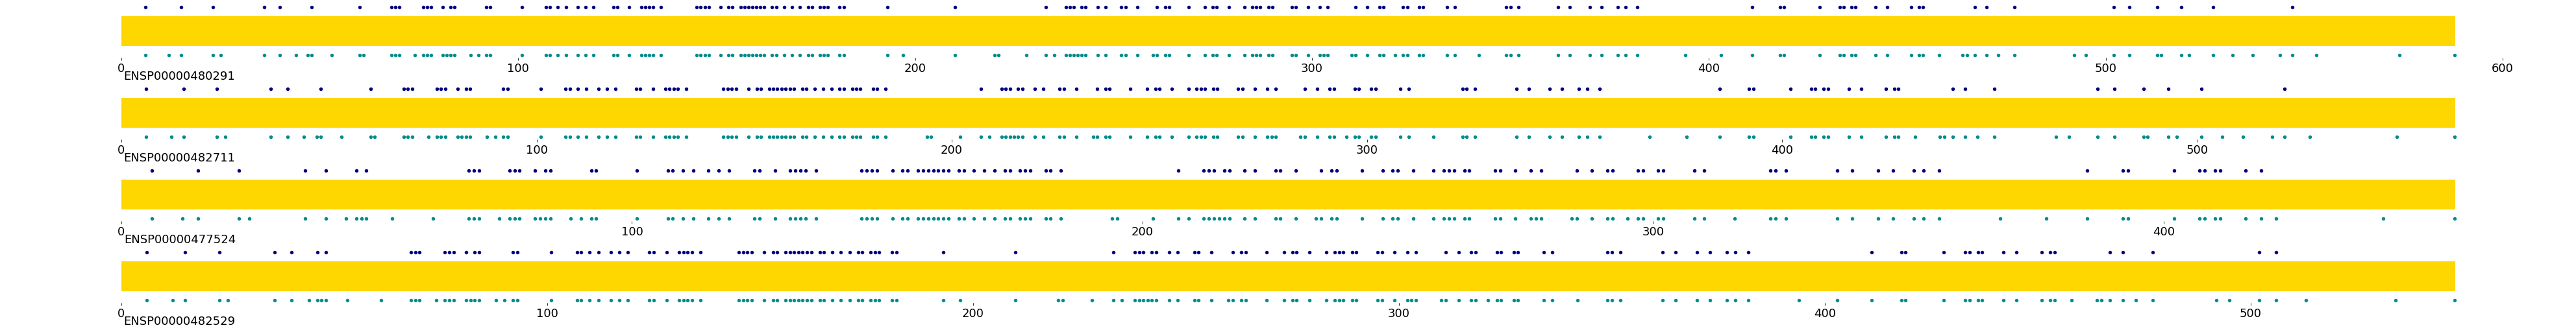

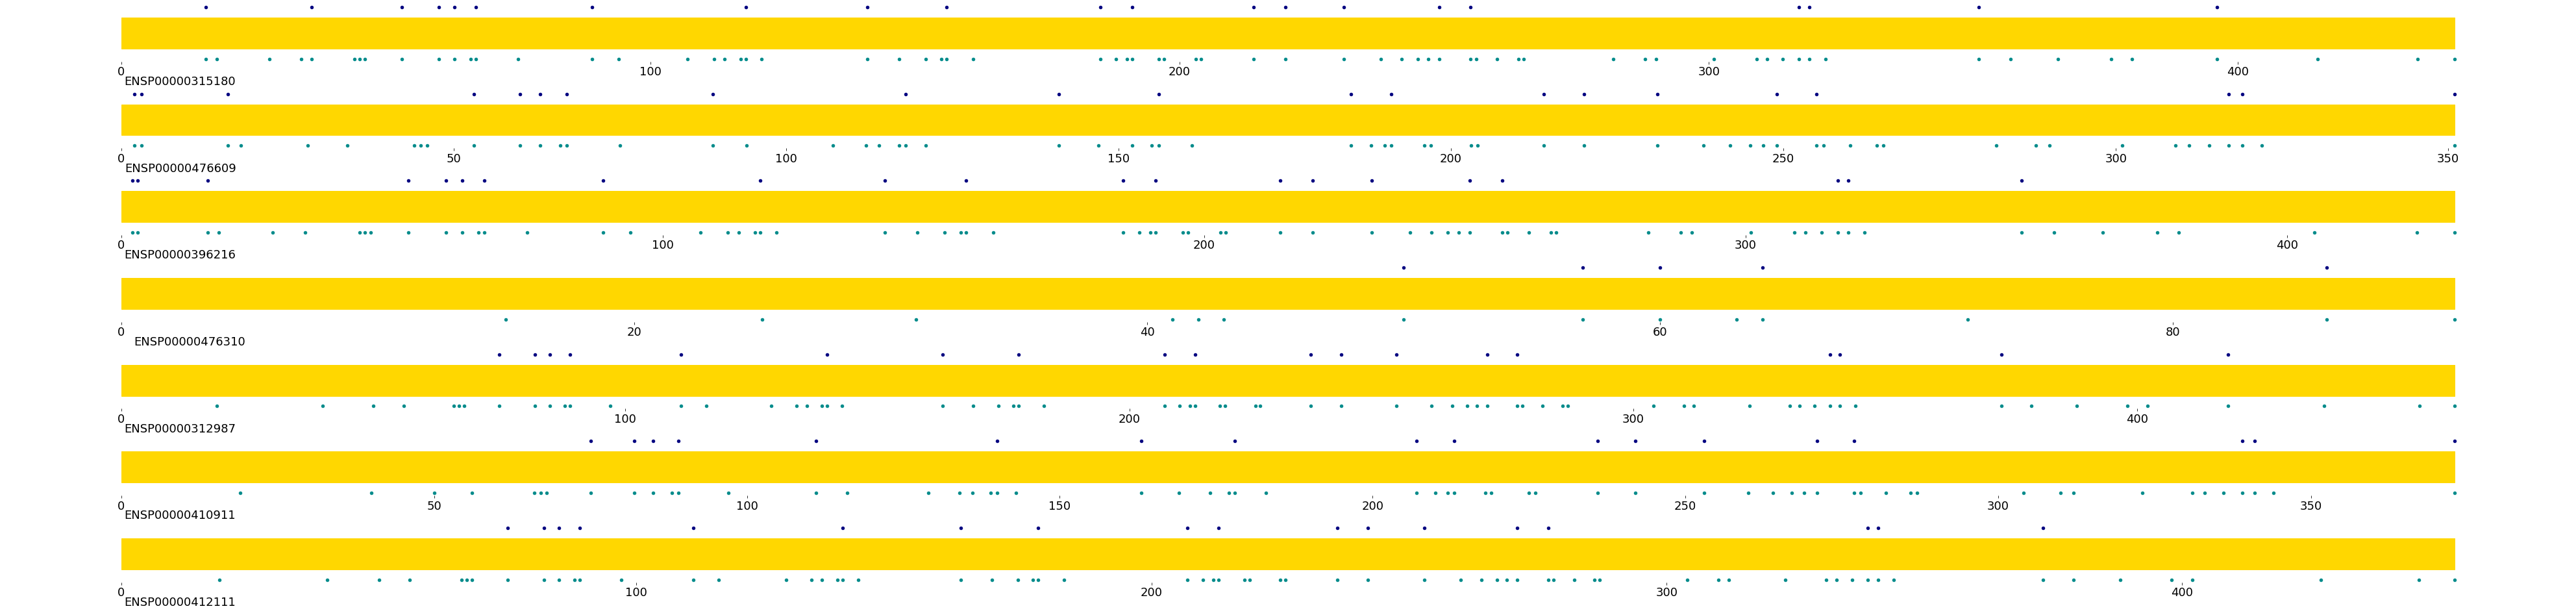

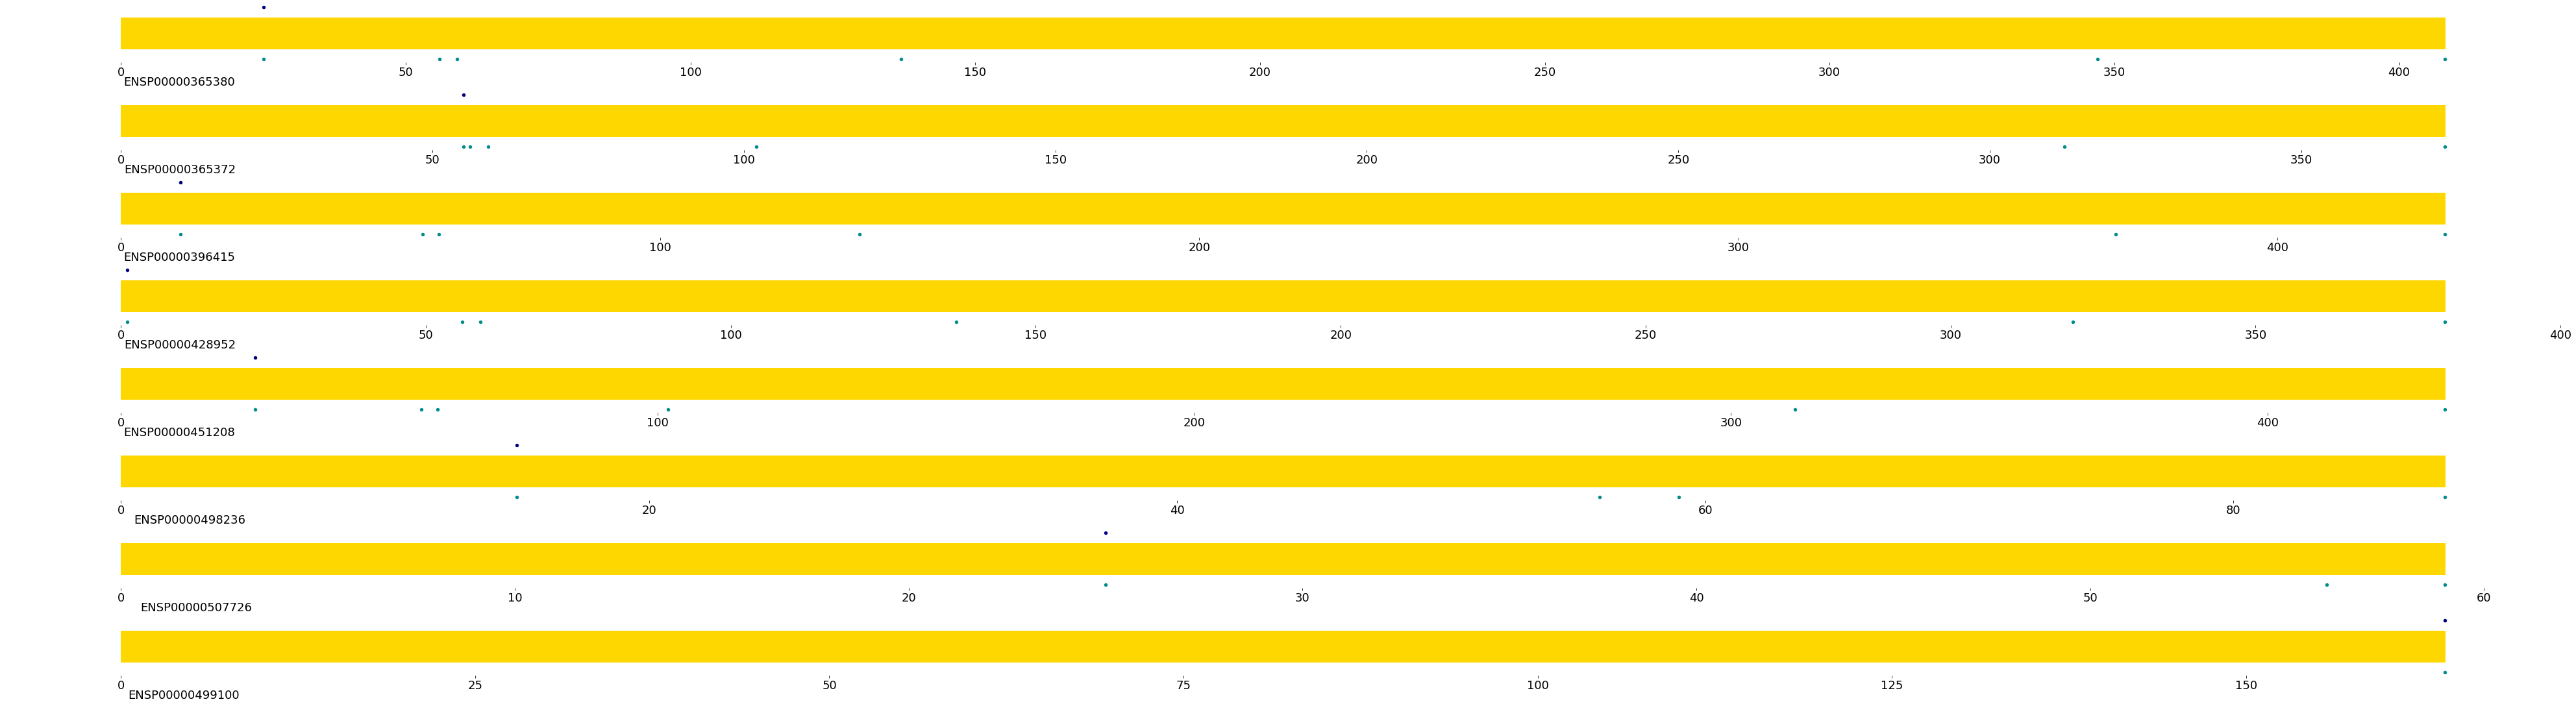

In [7]:
# Creating plots for the genes present in both levels. These plots will have two rows of dots: one for each level.

for gene in genes:
    if int(info_df['variants'][info_df['gene'] == gene]) > 10:
        gene_df = var_gene_names[var_gene_names['gene_name'] == gene]
        gene_df2 = var_gene_names2[var_gene_names2['gene_name'] == gene]
            
        number_of_transcr = int(info_df['transcripts'][info_df['gene'] == gene])
        fig = plt.figure(figsize=(55, (number_of_transcr * 2 - 1)), constrained_layout=True)
        gs = GridSpec(number_of_transcr, 1, figure=fig)
        
        pos_of_subplot = 0
        for proteinID in gene_df2['protein_id'].unique().tolist():
            single_prot_df = gene_df[gene_df['protein_id'] == proteinID].reset_index(drop=True)
            sequence = single_prot_df['unmodified_sequence'][0]
            protein_change = single_prot_df['protein_change'].drop_duplicates().tolist()
            protein_change.sort(key = lambda x: int(x.split(':')[0]))
            
            ### position1
            sequence_pos = []
            sequence = single_prot_df['unmodified_sequence'][0]
            for change in protein_change:
                if change[0] != '-':
                    pos = int(change.split(':')[0]) + 1
                    #if sequence[:pos][-1] != change.replace('>', ':').split(':')[1]:
                        #print(transcriptID, ' ', change)
                    if pos not in sequence_pos:
                        sequence_pos.append(pos)
                                    
            single_prot_df2 = gene_df2[gene_df2['protein_id'] == proteinID].reset_index(drop=True)
            sequence2 = single_prot_df2['unmodified_sequence'][0]
            prot_change2 = single_prot_df2['protein_change'].drop_duplicates().tolist()
            prot_change2.sort(key = lambda x: int(x.split(':')[0]))
                        
            ### position2
            sequence_pos2 = []
            sequence2 = single_prot_df2['unmodified_sequence'][0]
            for change in prot_change2:
                if change[0] != '-':
                    pos2 = int(change.split(':')[0]) + 1
                    if pos2 not in sequence_pos2:
                        sequence_pos2.append(pos2)
                        
            y_numbers = str(1) * len(sequence_pos)
            y_int_number_list = []
            for el in y_numbers:
                y_int_number_list.append(int(el))
            y_numbers_2 = str(2) * len(sequence_pos2)
            y_numbers_2_list = []
            for el in y_numbers_2:
                y_numbers_2_list.append(int(el))
            
            ax = fig.add_subplot(gs[pos_of_subplot, :])    
            ax.scatter(sequence_pos, y_int_number_list, s=20, label="all_var", color='darkcyan')
            ax.scatter(sequence_pos2, y_numbers_2_list, s=20, label="short_list", color='navy')
            ax.add_patch(Rectangle((0, 1.2), max(sequence_pos), 0.6, color='gold'))
            ax.yaxis.set_visible(False)
            ax.spines[["left", "top", "right", "bottom"]].set_visible(False)
            ax.text(0.5, 0.5, proteinID, fontsize=18)
            ax.tick_params(labelsize=18)
            pos_of_subplot = pos_of_subplot + 1
                
        fig.savefig(
            '/Users/ksenia/Documents/MODY_genes/whole_pipeline_311022/drafts/' + 
            gene + '_protein.png', dpi=300, format='png')
        print(gene)


## 4. Plotting the rest of genes from the level1 table without the level2 variants

These plots will have just one row of dots

In [9]:
level1_only_genes = set(var_gene_names['gene_name'].unique()) - set(var_gene_names2['gene_name'].unique())
level1_only_genes

{'AGPAT2',
 'AKT2',
 'ALMS1',
 'ASB14',
 'BSCL2',
 'CAV1',
 'CAVIN1',
 'EDEM2',
 'EFL1',
 'FOXP1',
 'GATA4',
 'GATA6',
 'GLUD1',
 'GRIN2B',
 'HADH',
 'HBB',
 'IER3IP1',
 'INSR',
 'ITGB3',
 'KCNH2',
 'KMT2E',
 'LAMA2',
 'LEPR',
 'LMNA',
 'MBL2',
 'MC4R',
 'MECP2',
 'NLRP3',
 'PARK7',
 'PAX2',
 'PDIA6',
 'PLIN1',
 'PPARG',
 'PPP1R3A',
 'PRKAG2',
 'RET',
 'SHLD2',
 'SIM1',
 'SLC19A2',
 'WFS1'}

GATA6
MC4R
PPARG
ALMS1
AGPAT2
WFS1
INSR
HADH
PLIN1
AKT2
PPP1R3A
LEPR
LMNA
BSCL2
SLC19A2
EFL1


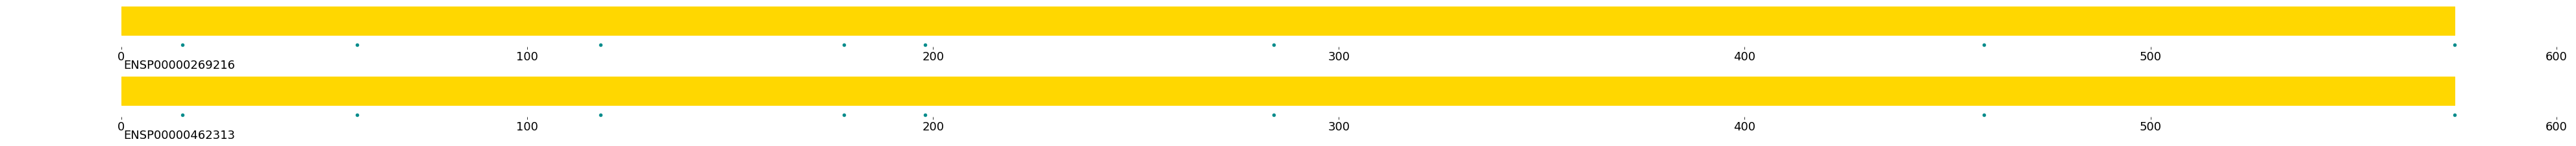

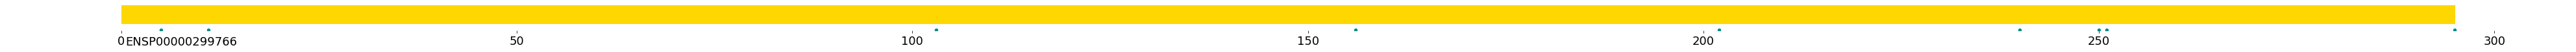

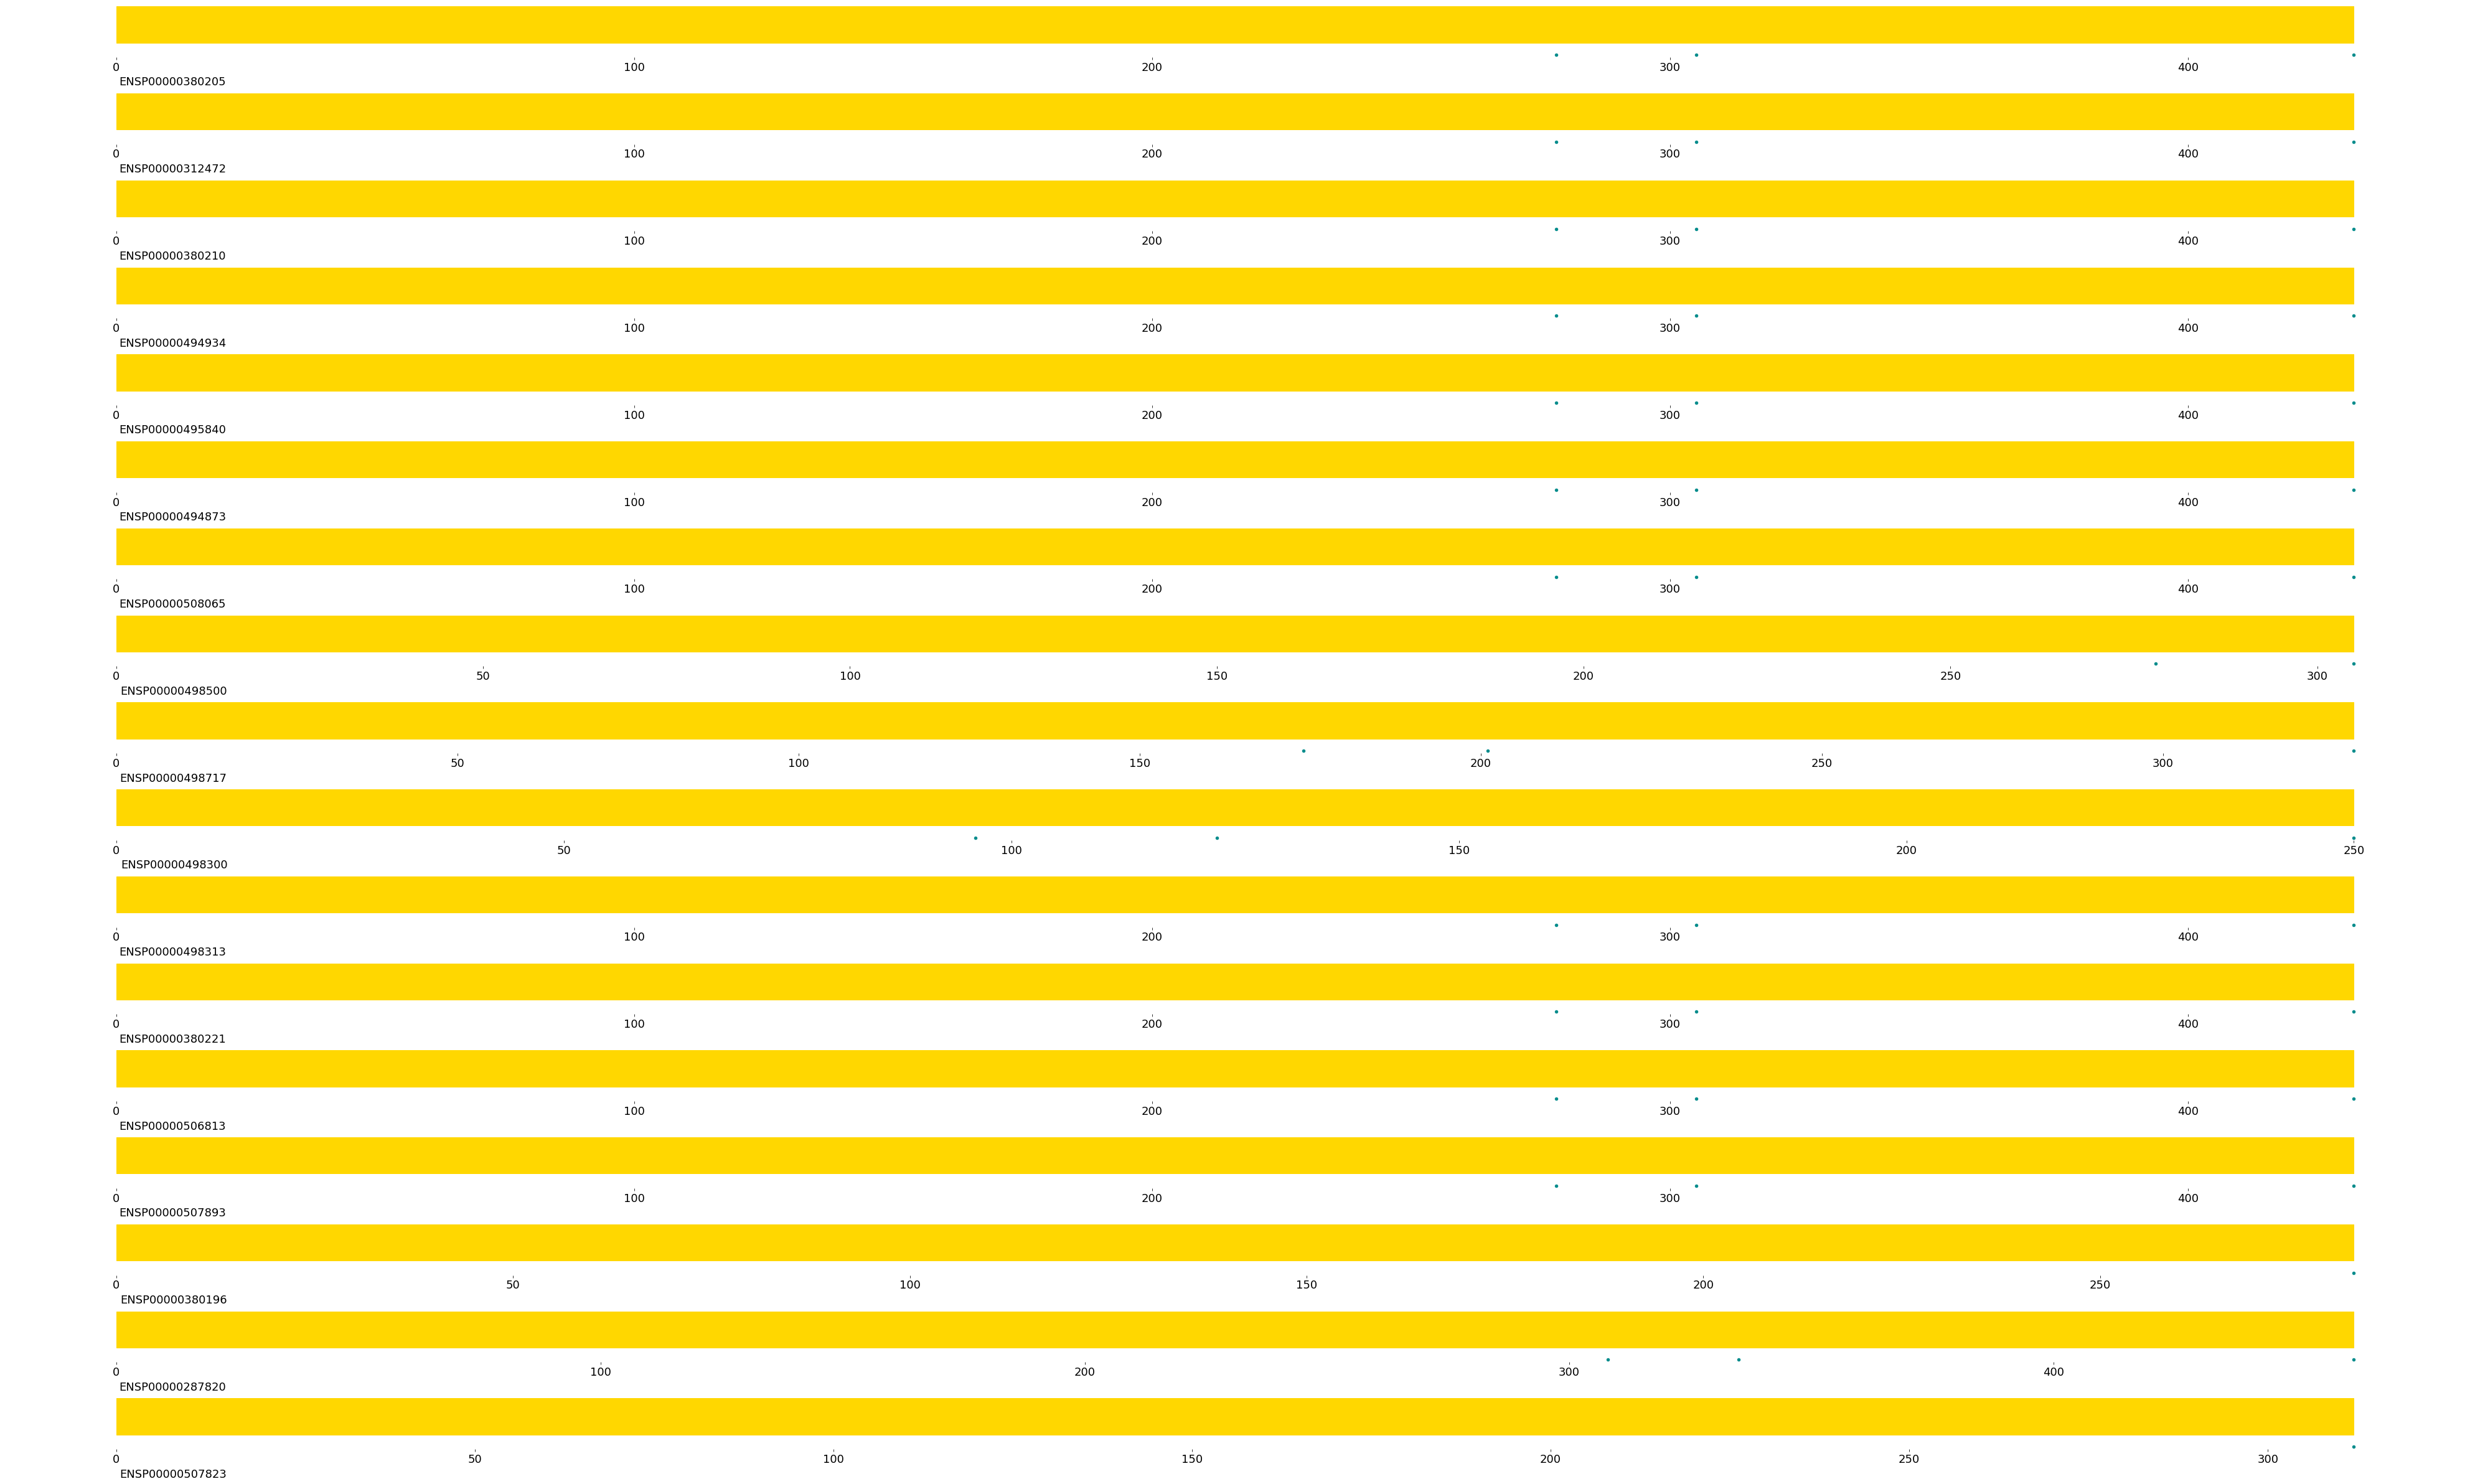

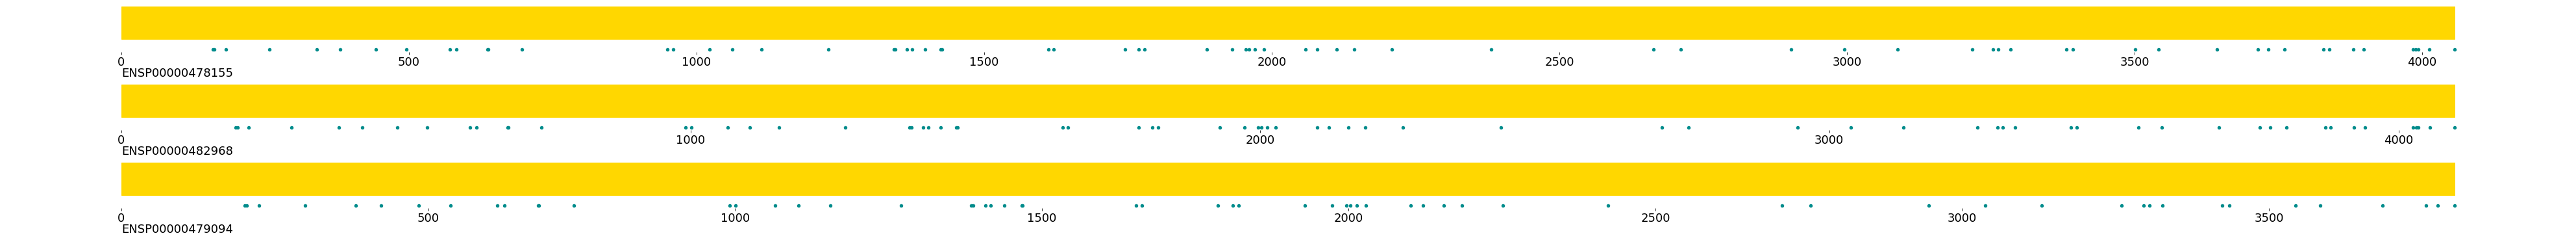

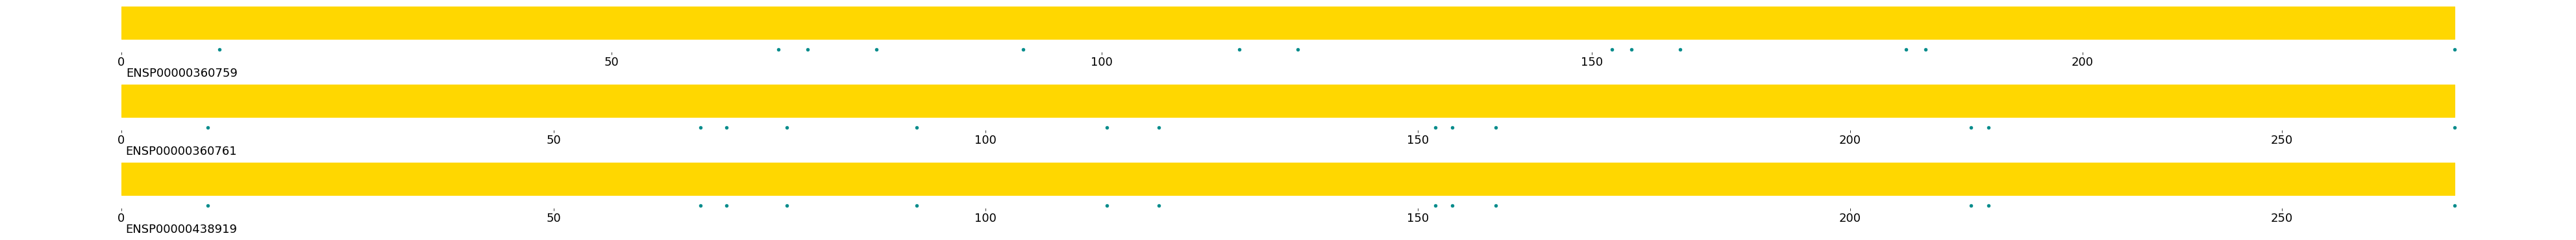

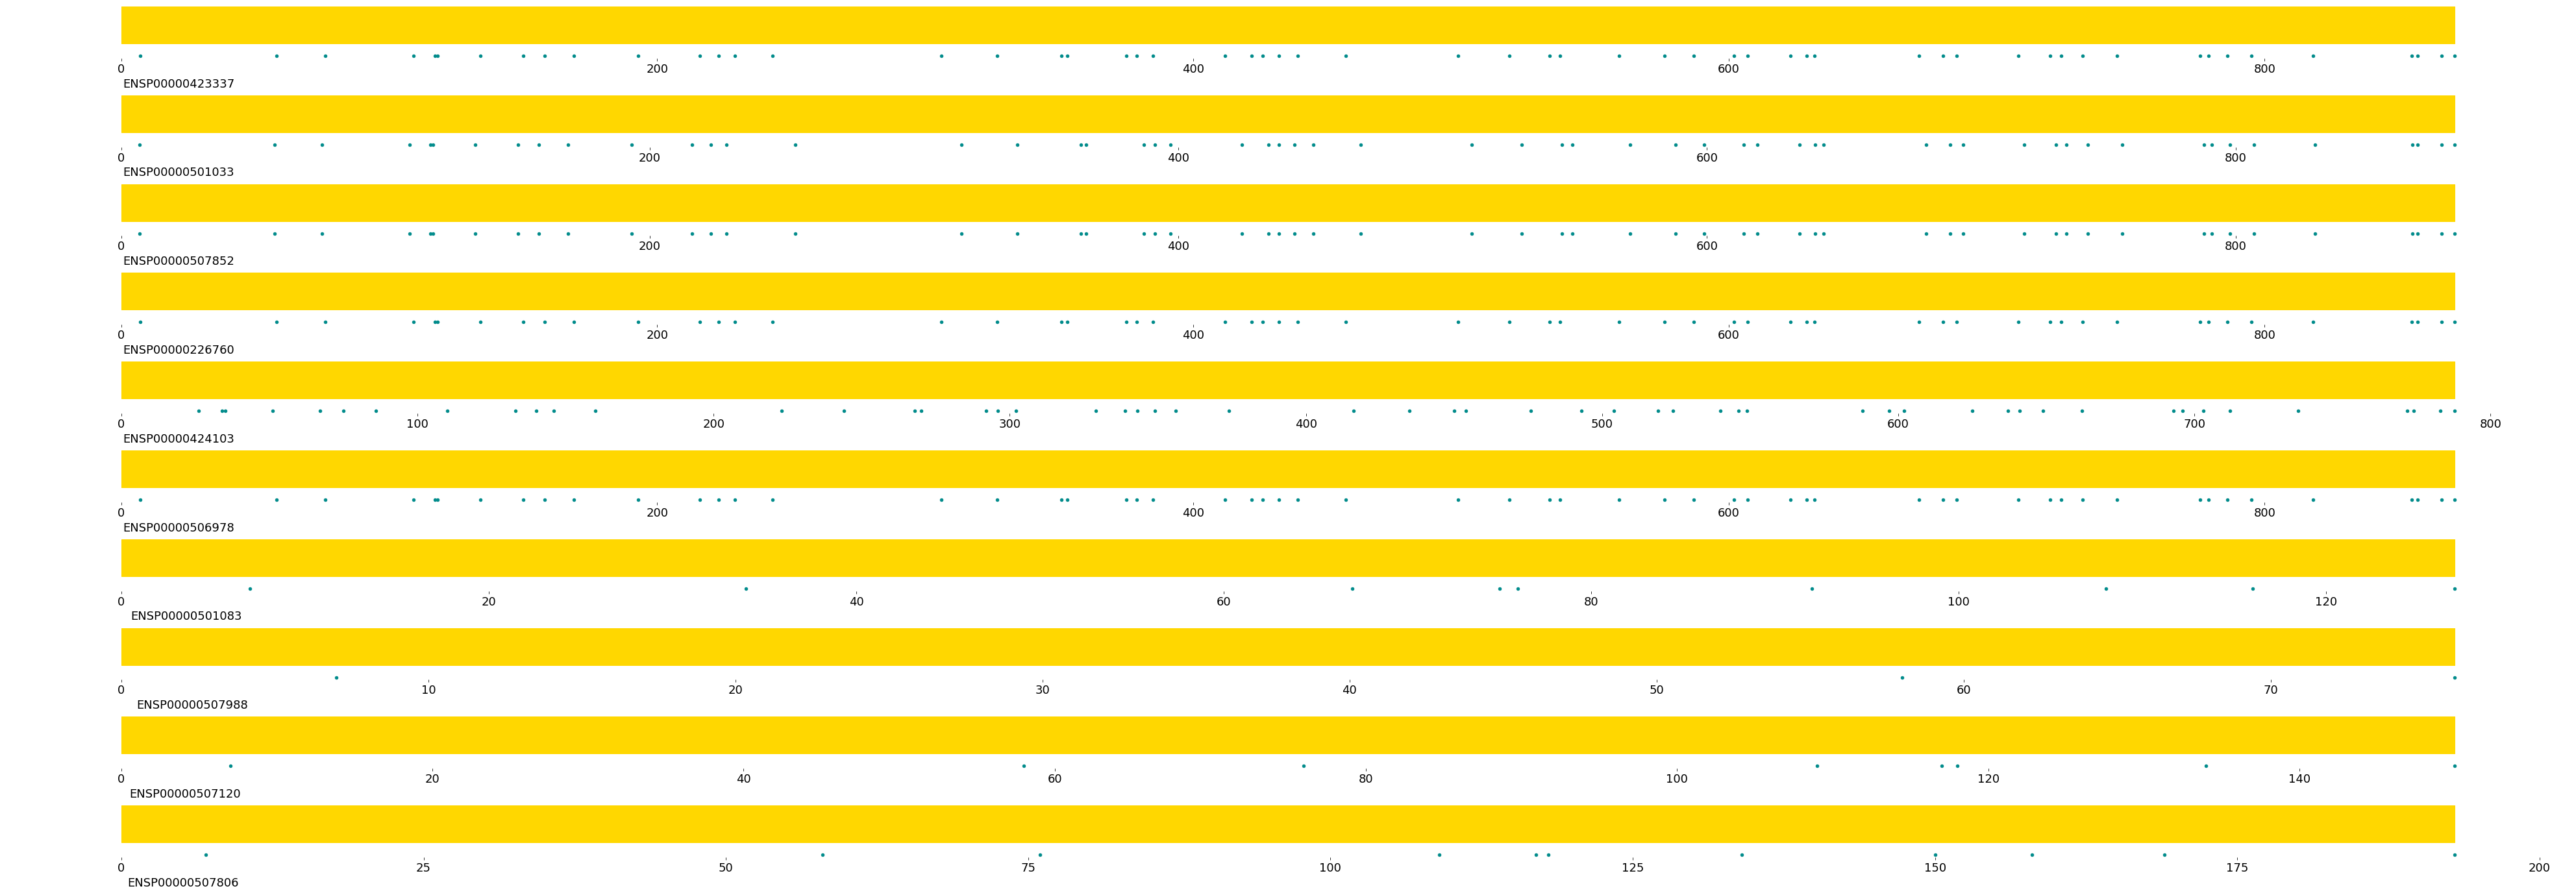

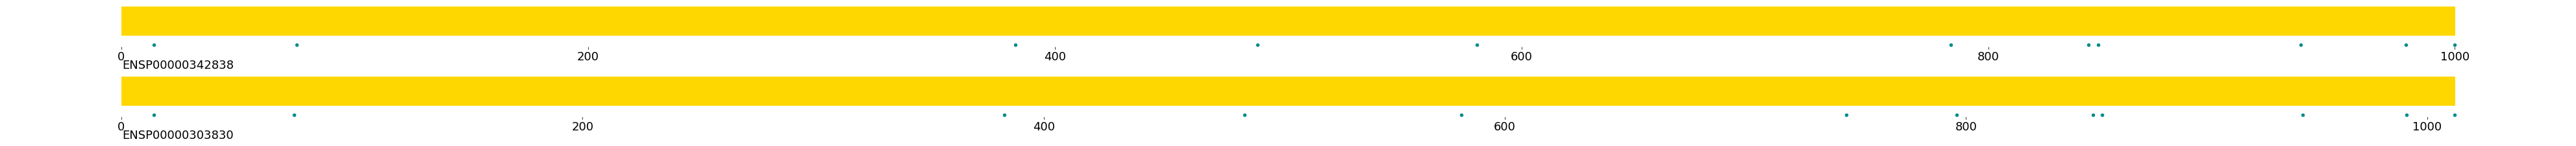

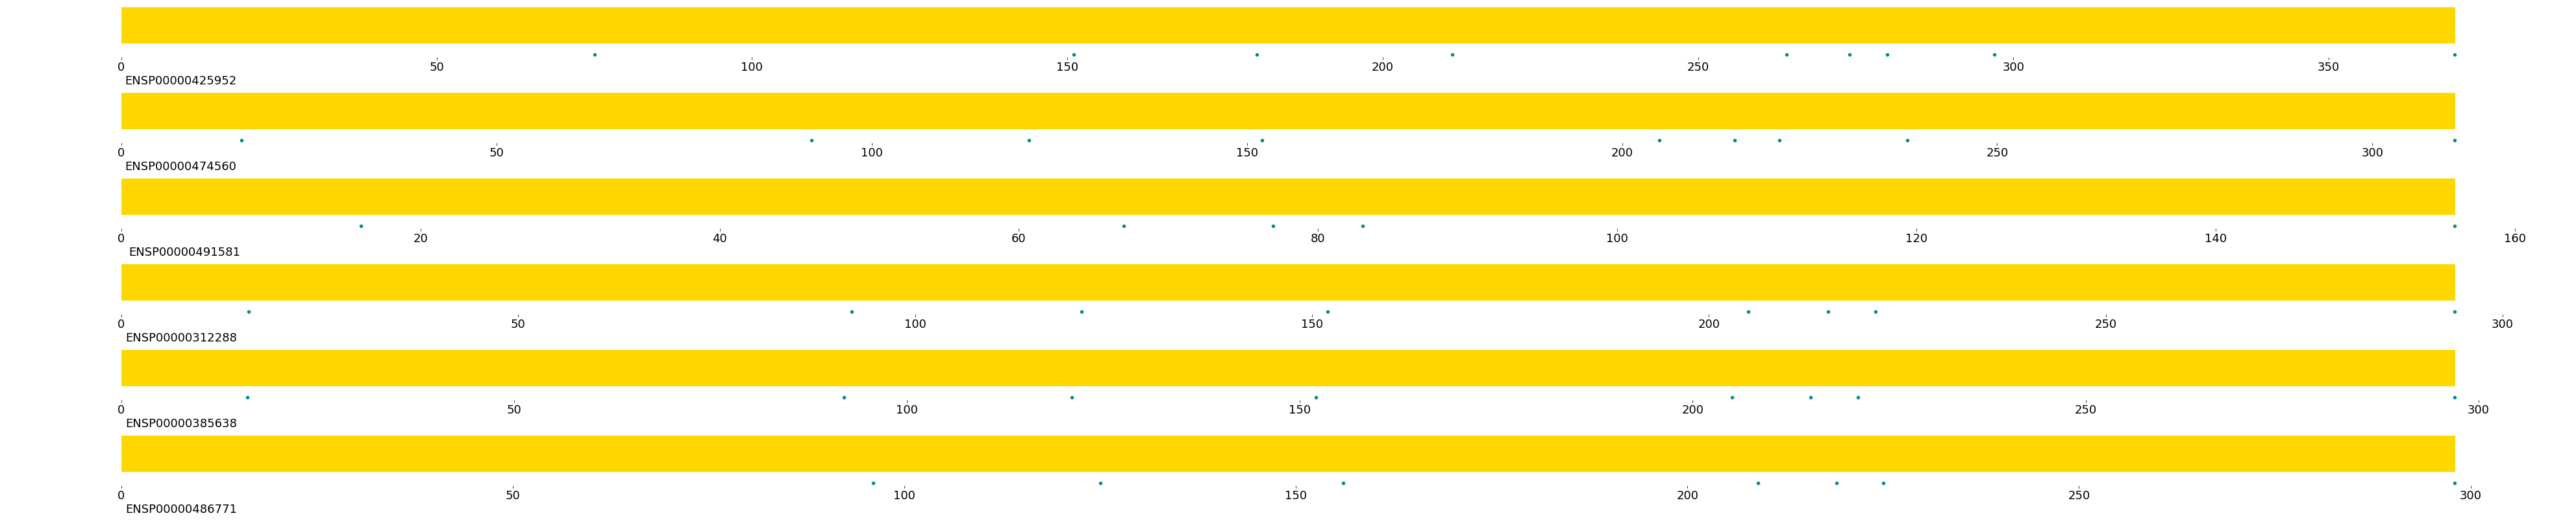

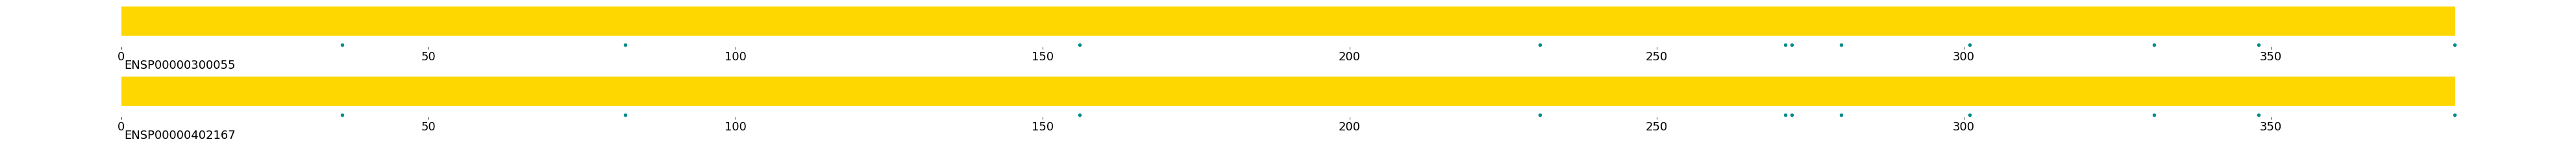

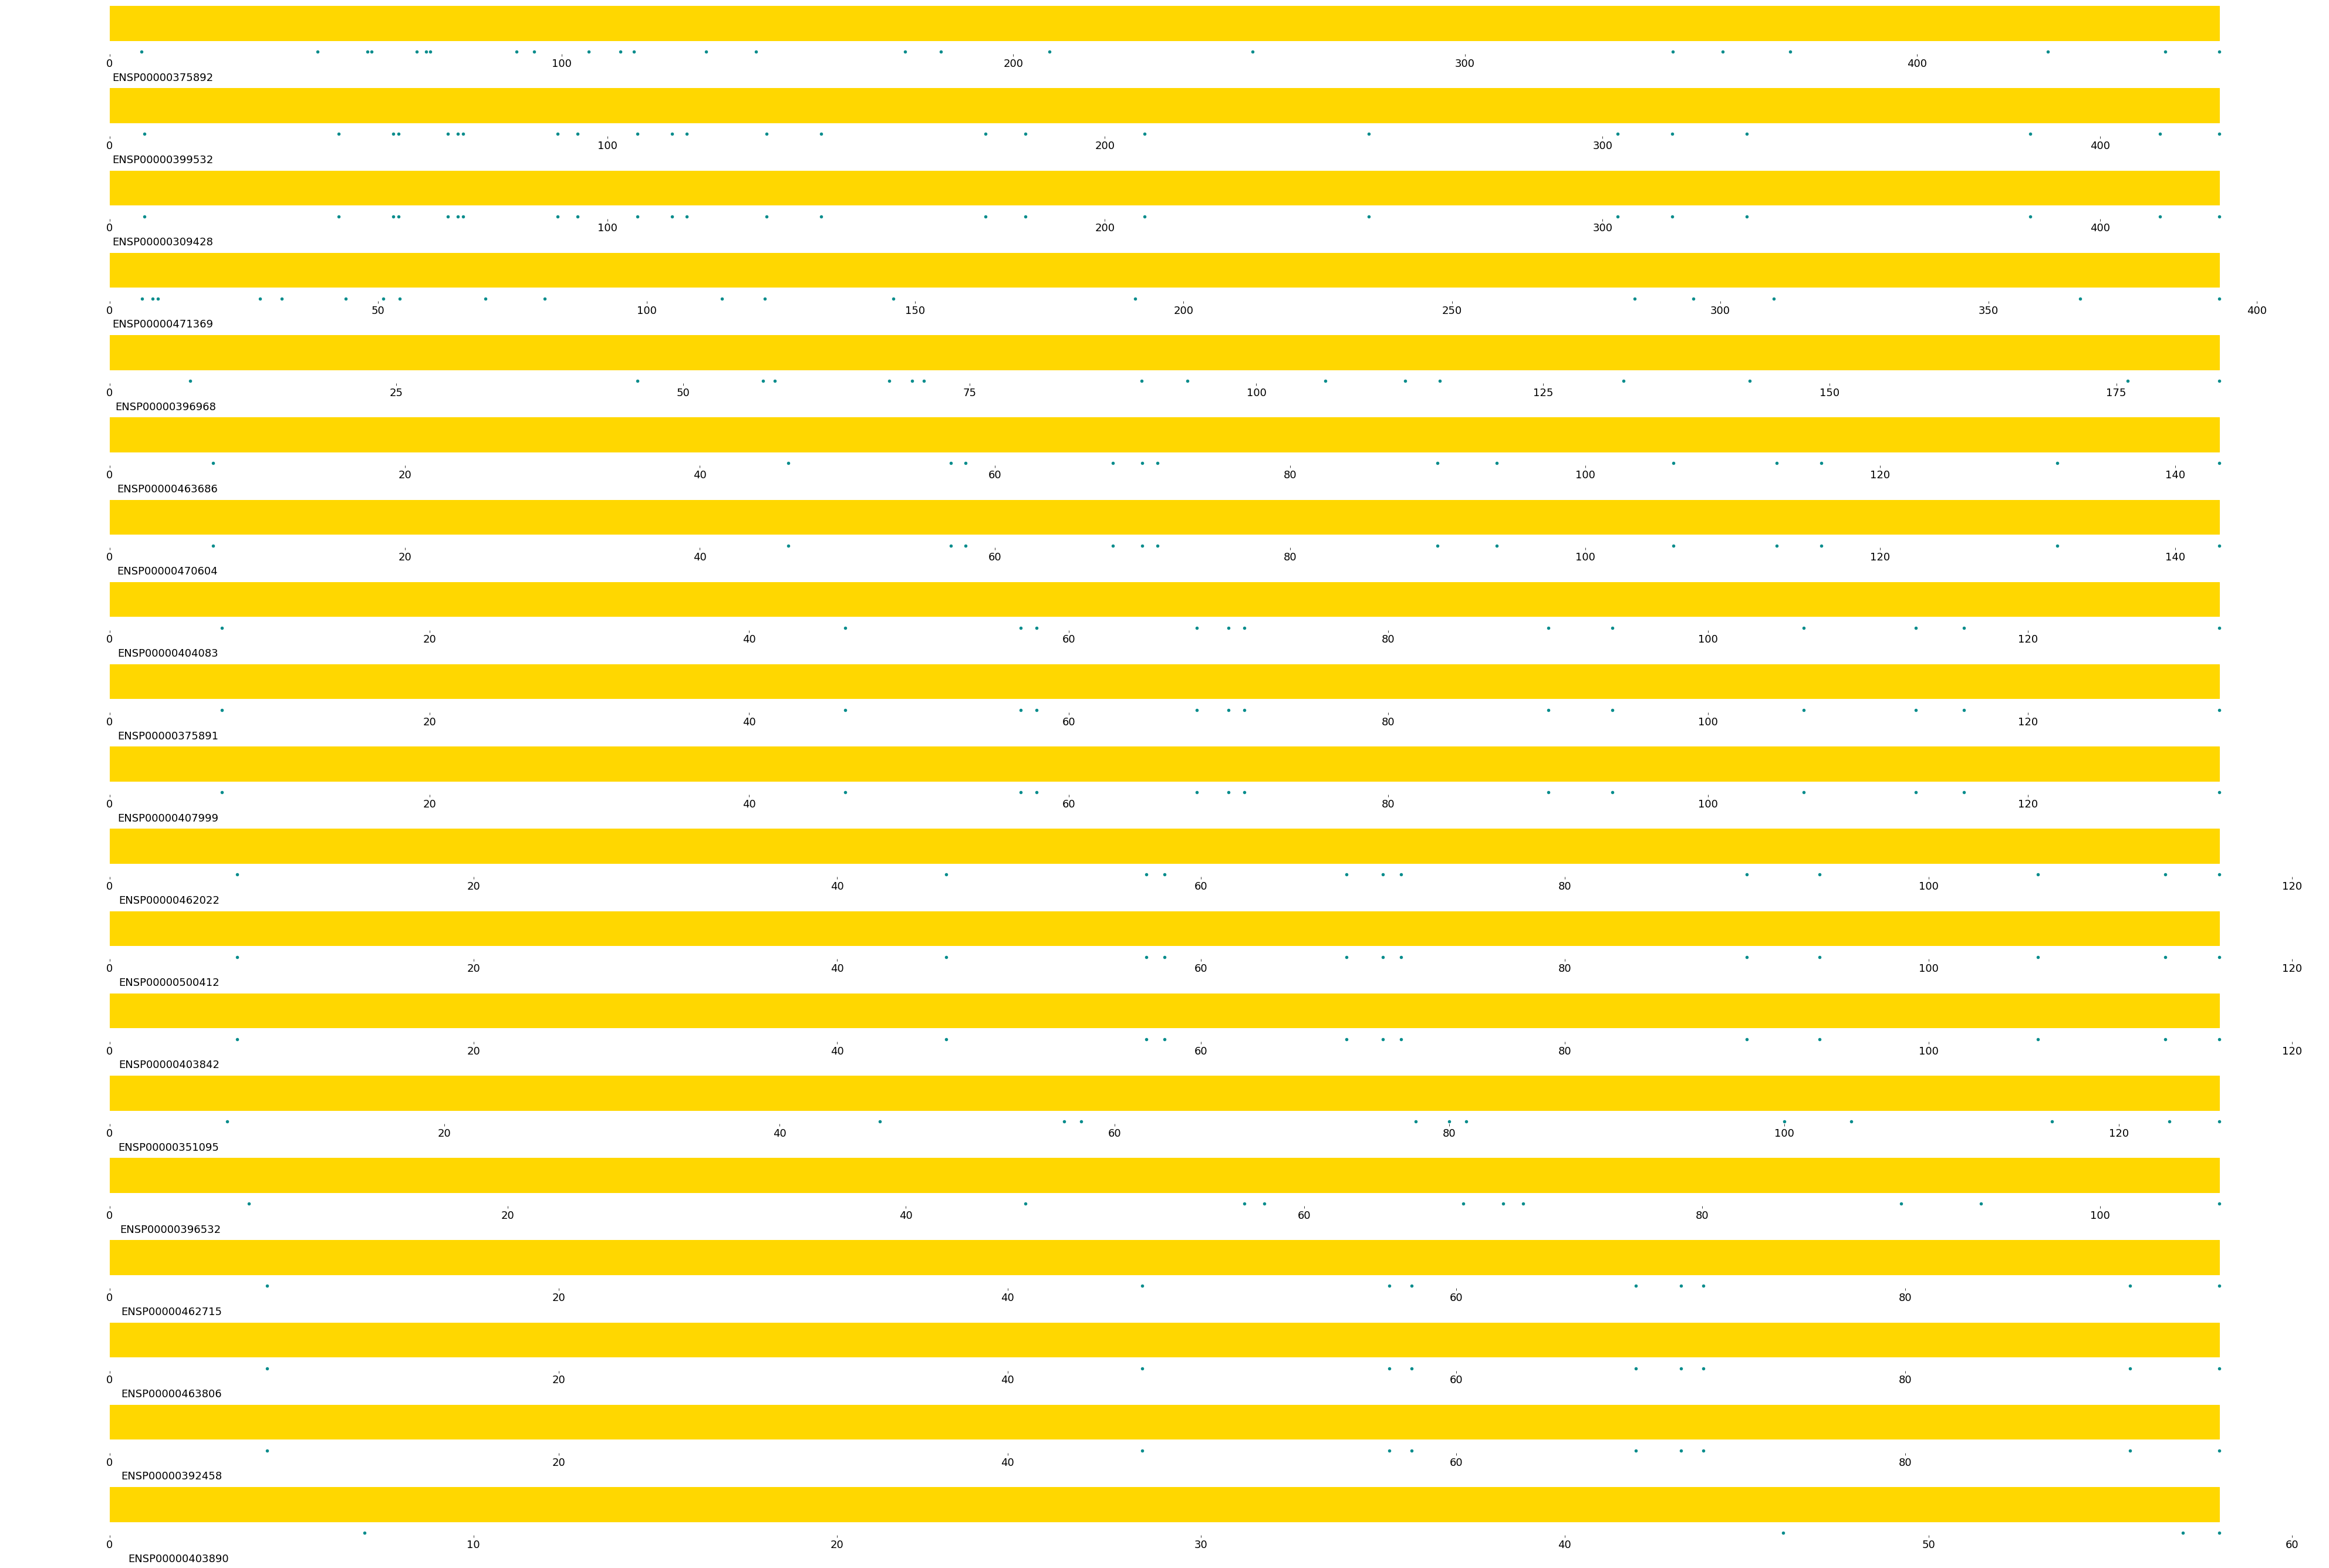

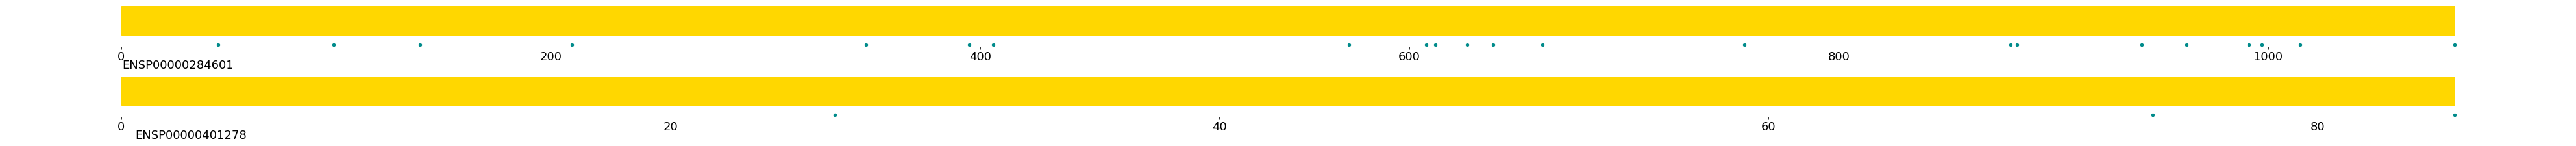

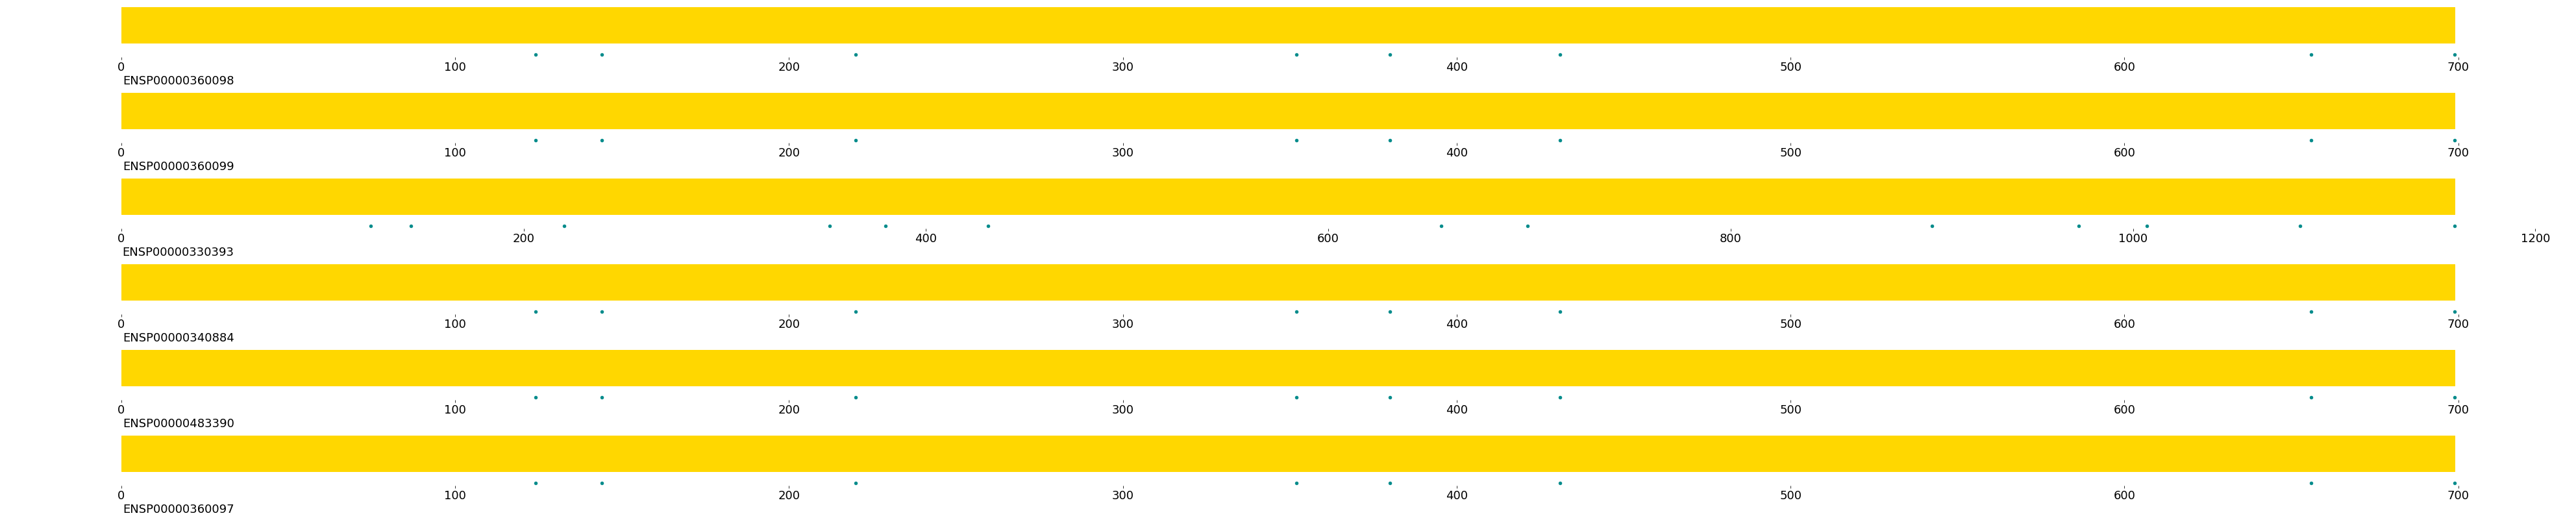

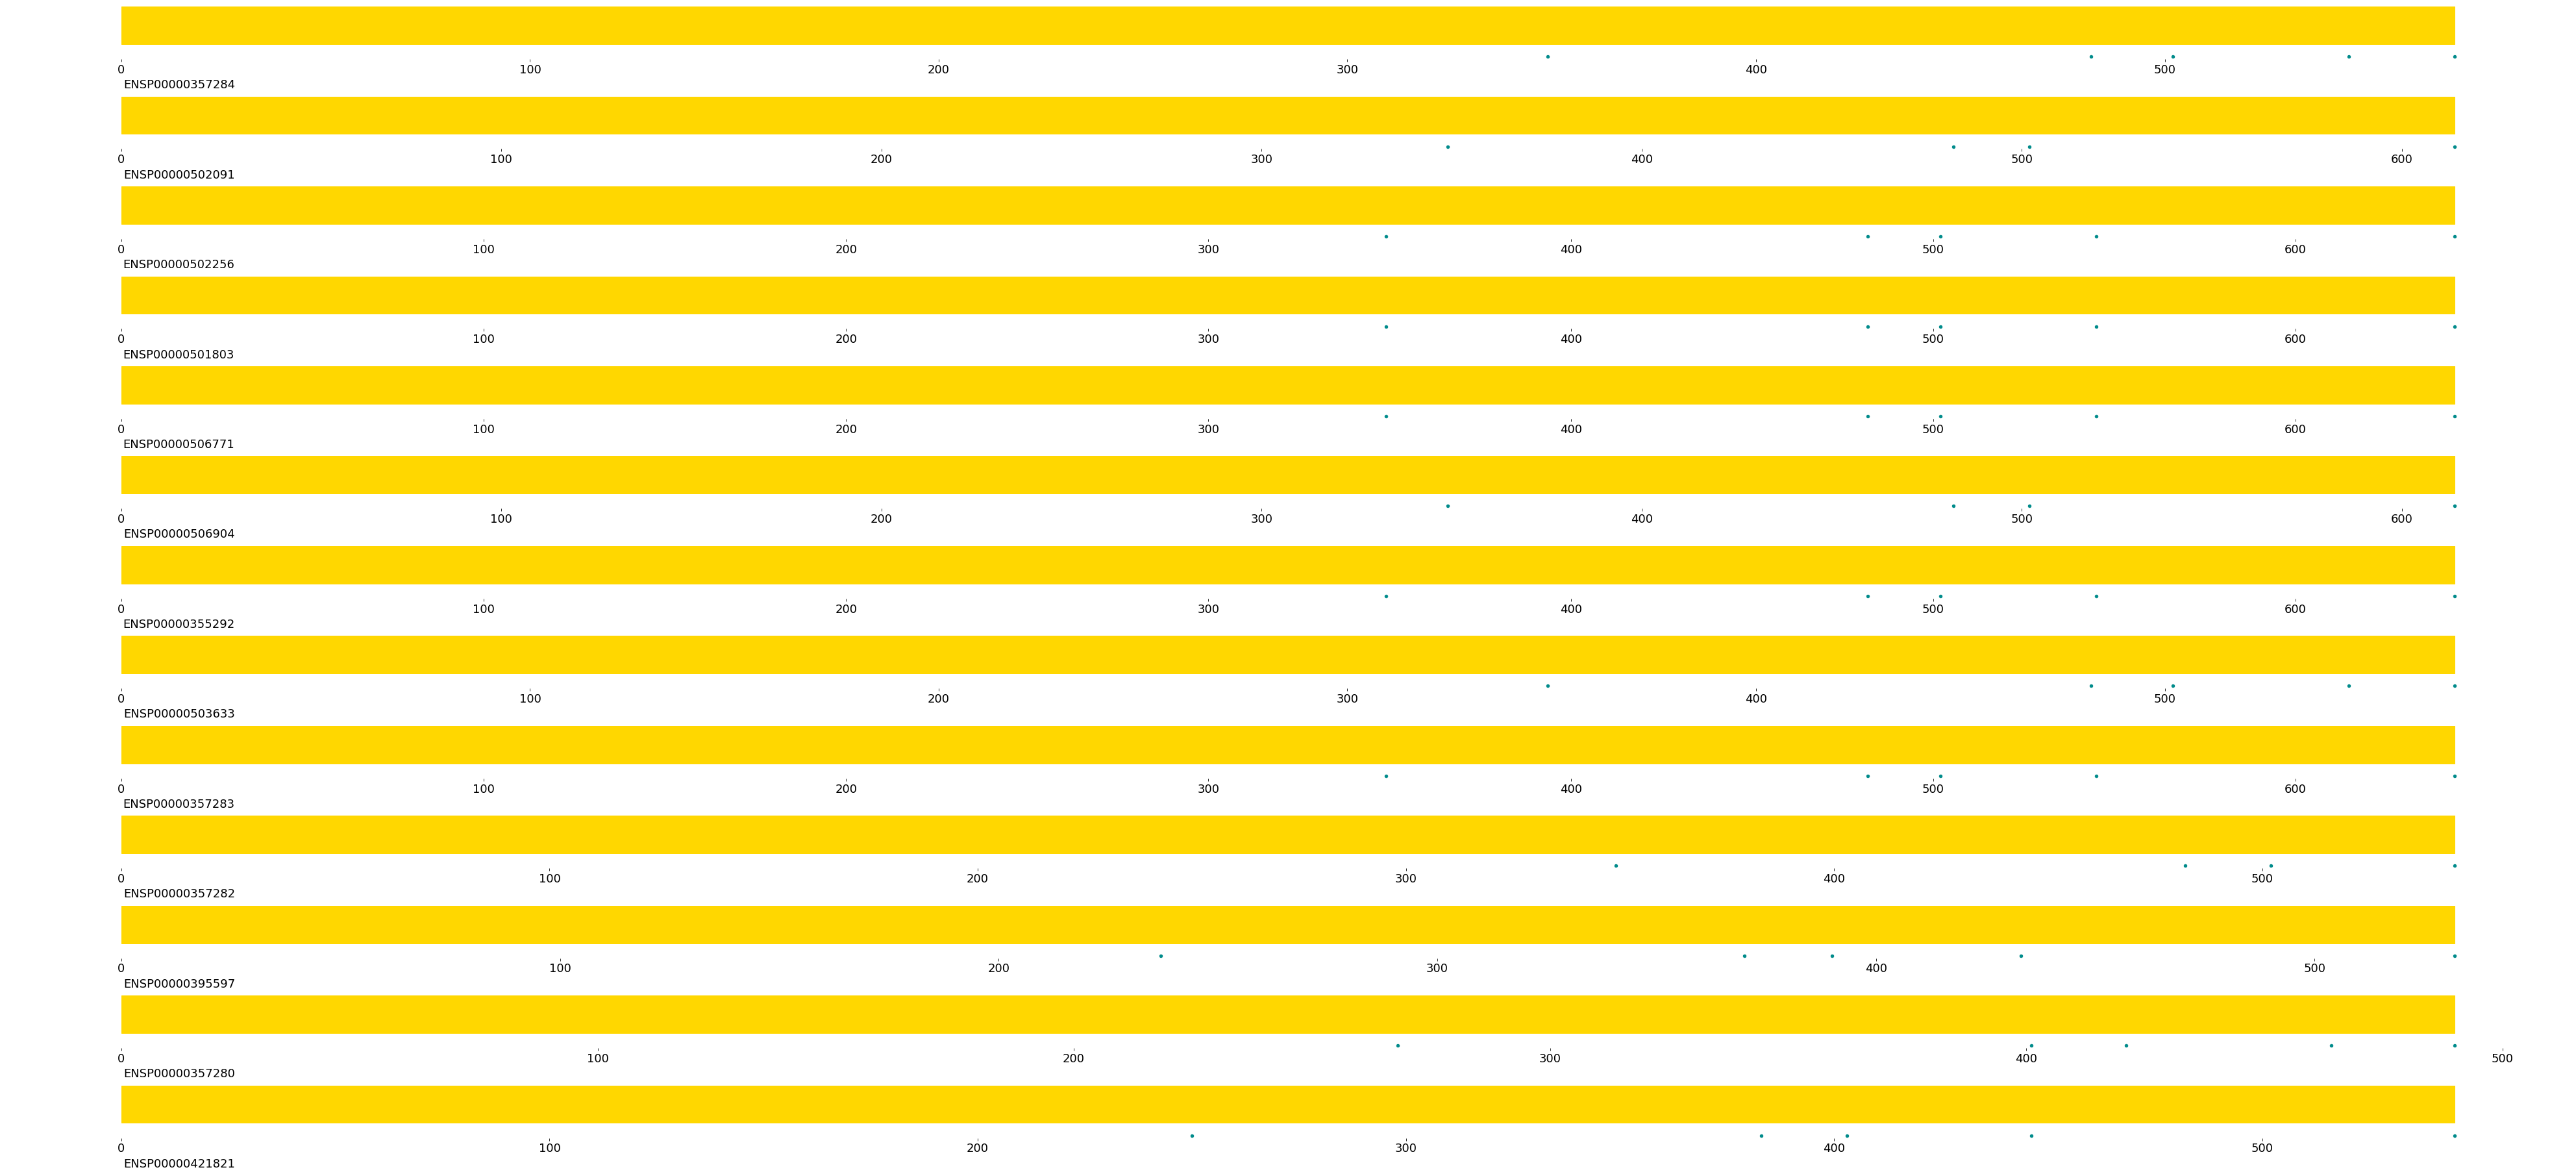

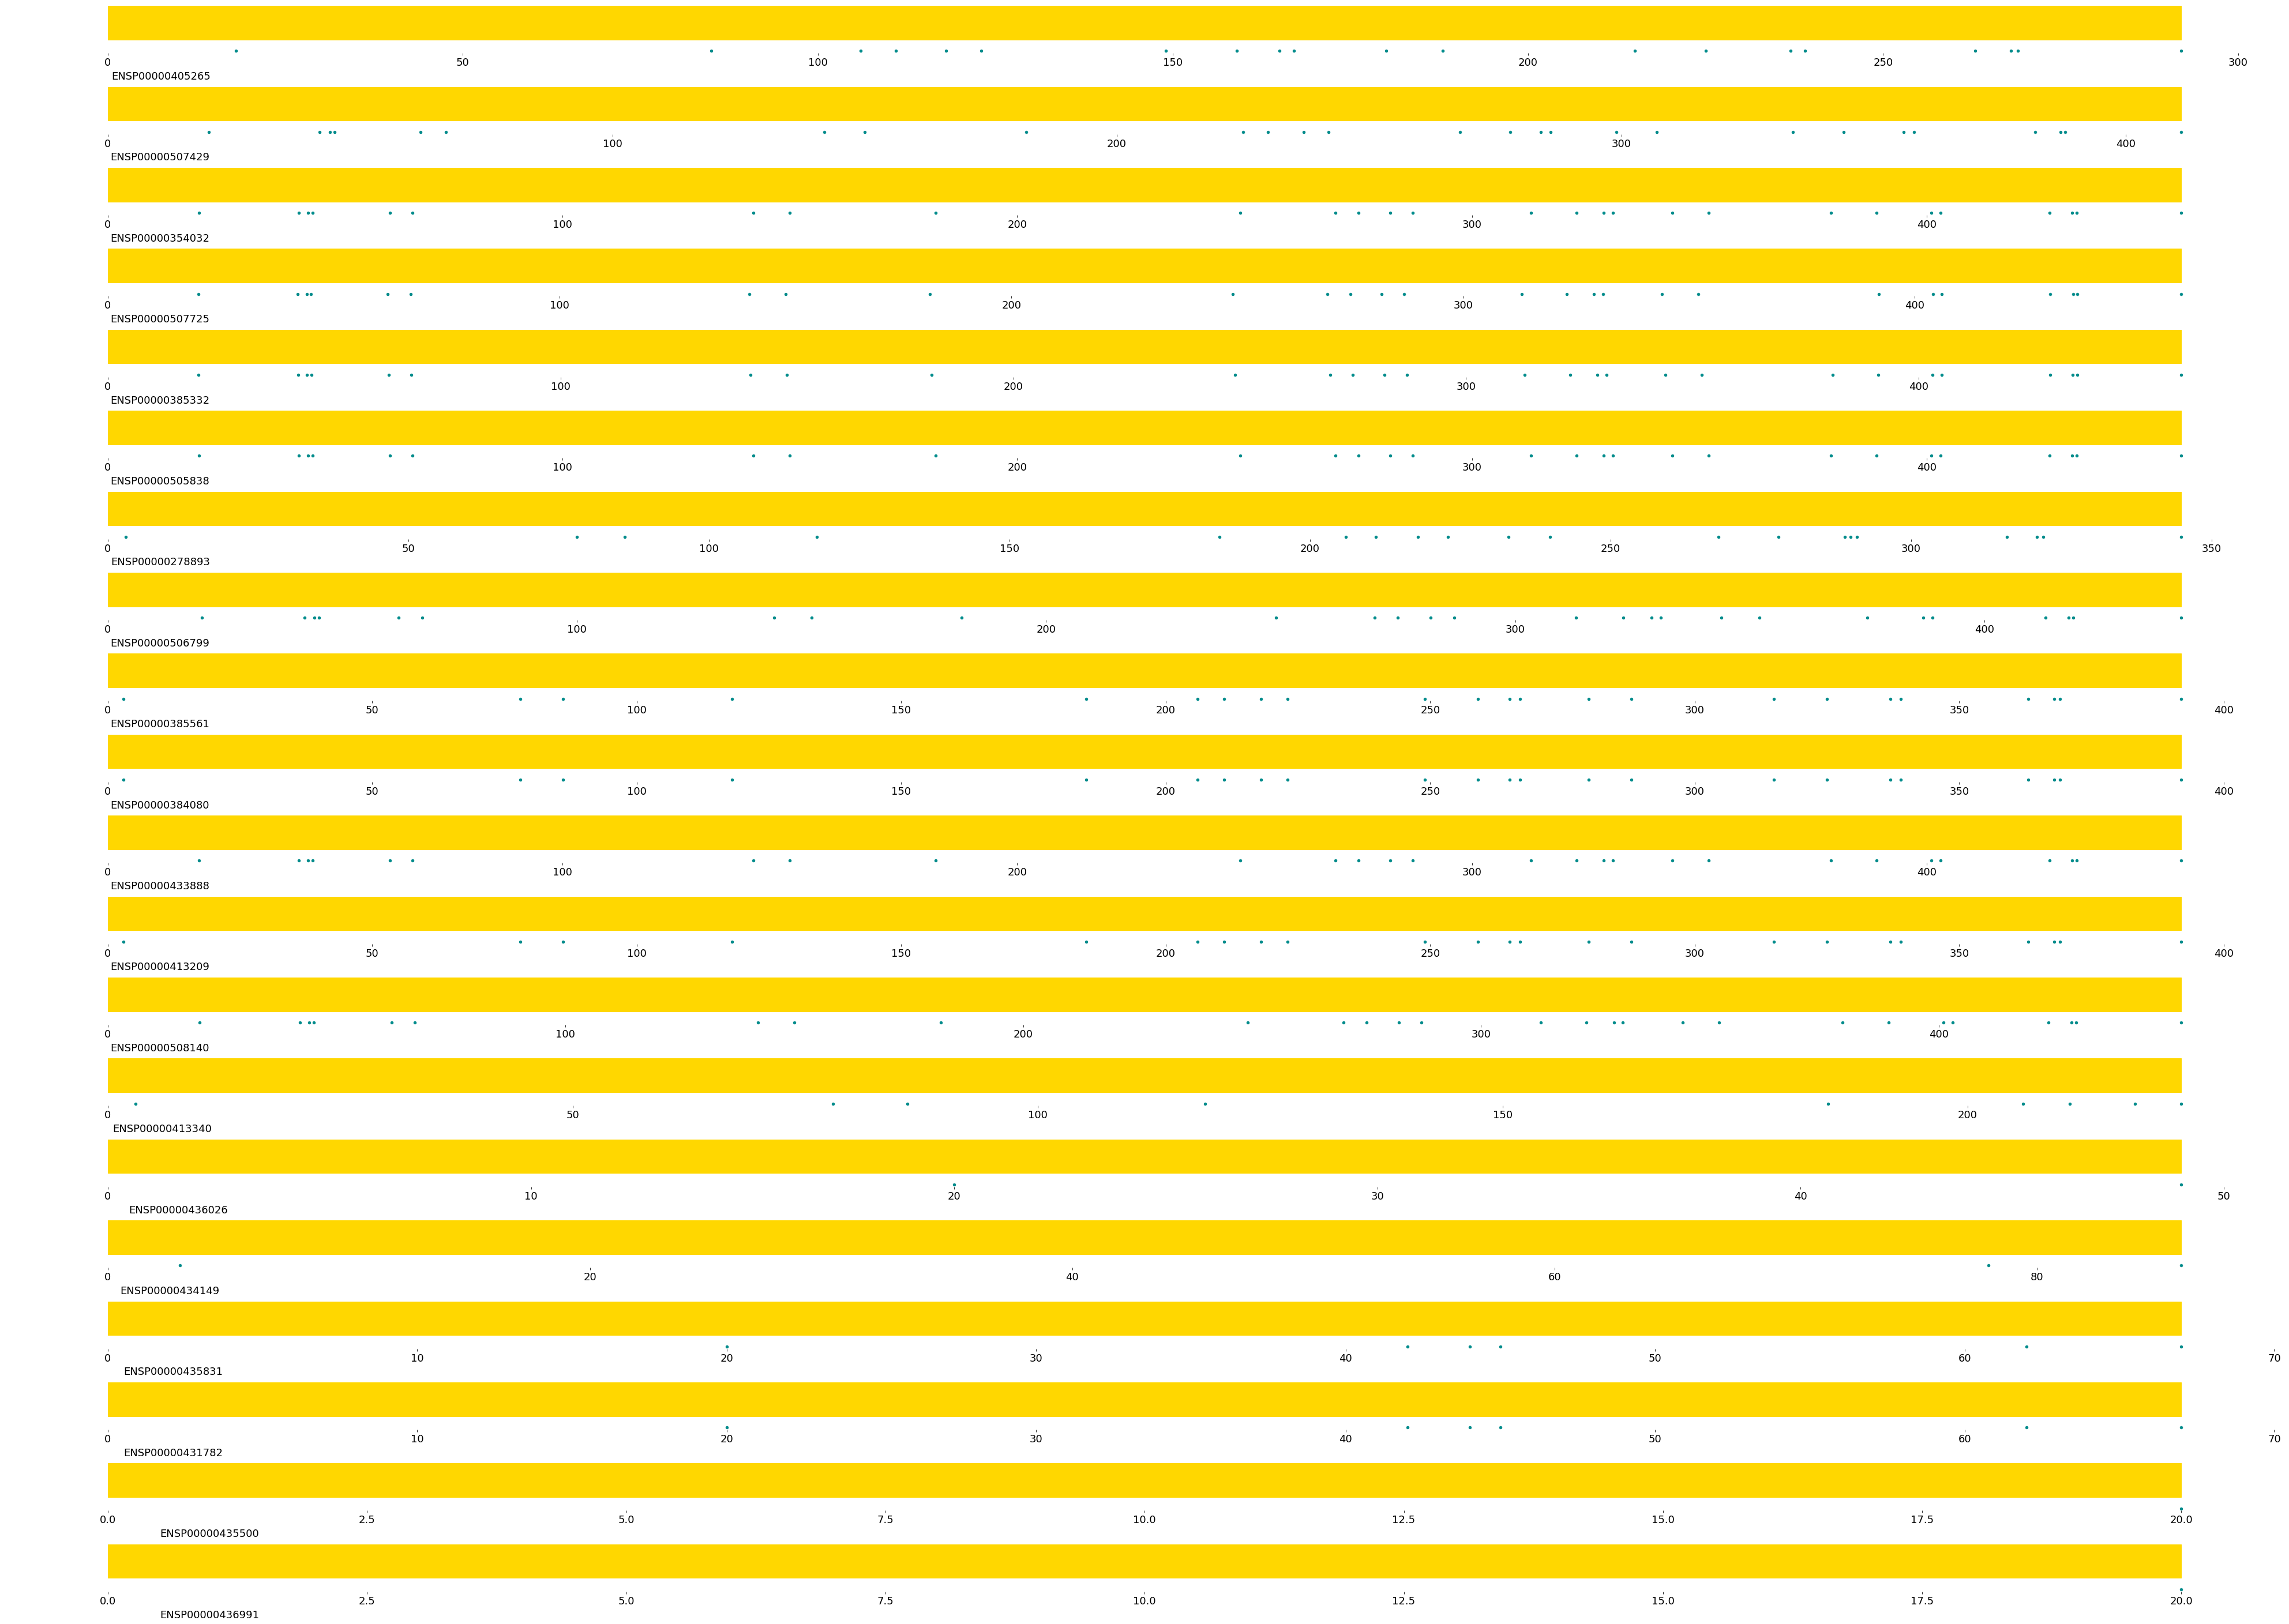

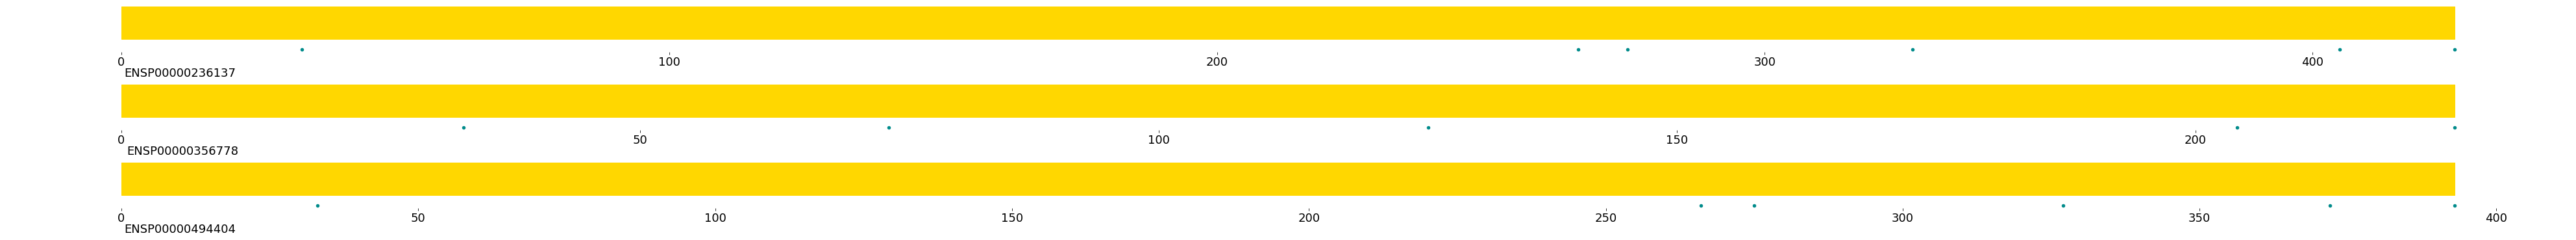

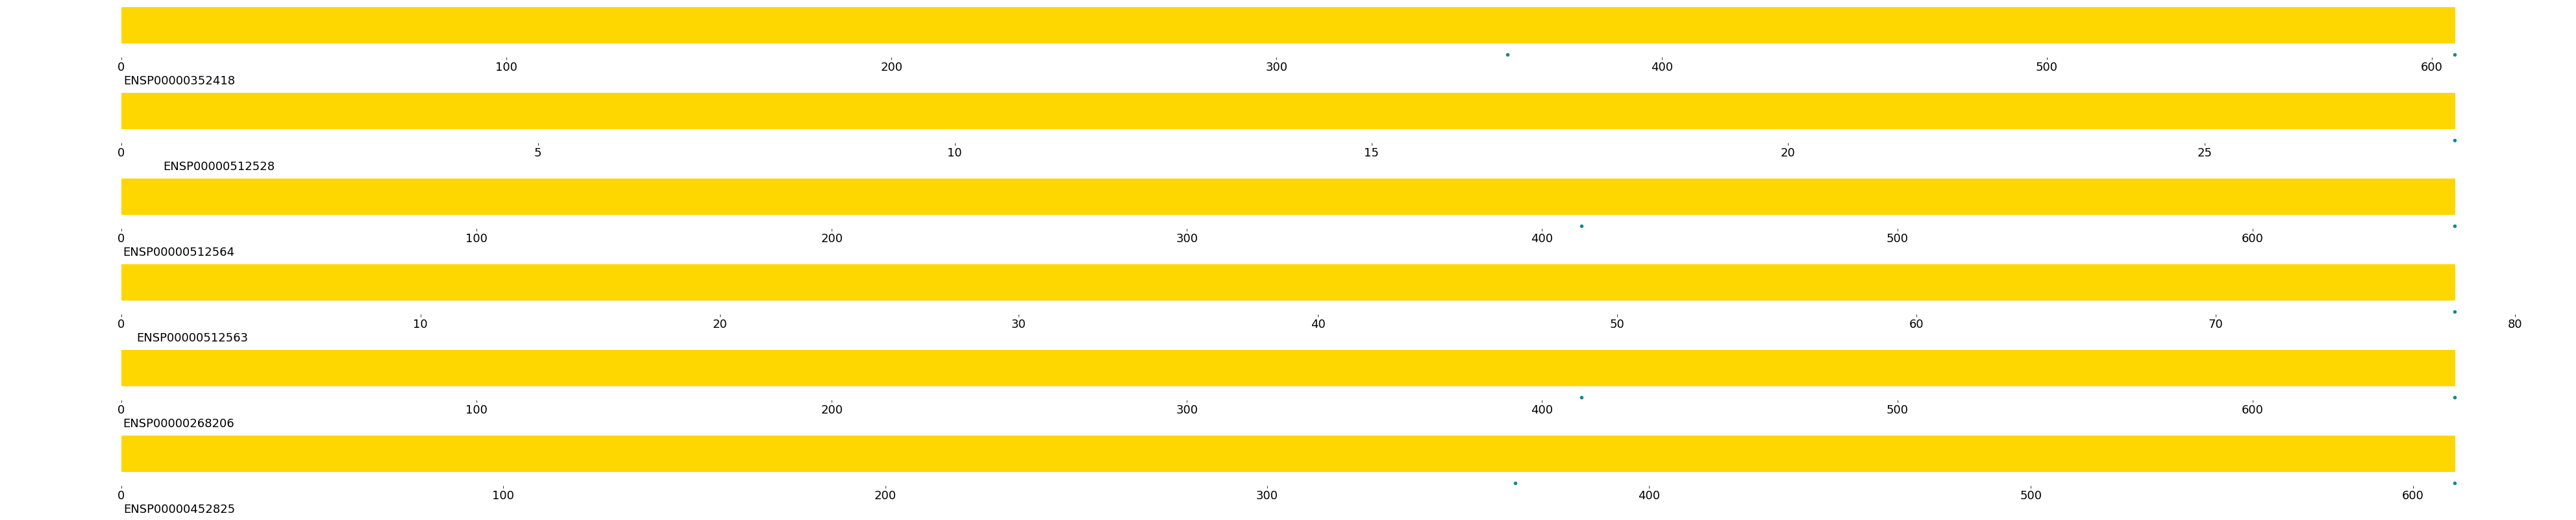

In [11]:
for gene in level1_only_genes:
    if int(info_df['variants'][info_df['gene'] == gene]) > 10:
        gene_df = var_gene_names[var_gene_names['gene_name'] == gene]
        
        number_of_transcr = int(info_df['transcripts'][info_df['gene'] == gene])
        fig = plt.figure(figsize=(55, (number_of_transcr * 2 - 1)), constrained_layout=True)
        gs = GridSpec(number_of_transcr, 1, figure=fig)
        
        pos_of_subplot = 0
        for proteinID in gene_df['protein_id'].unique().tolist():
            single_prot_df = gene_df[gene_df['protein_id'] == proteinID].reset_index(drop=True)
            sequence = single_prot_df['unmodified_sequence'][0]
            prot_change = single_prot_df['protein_change'].drop_duplicates().tolist()
            prot_change.sort(key = lambda x: int(x.split(':')[0]))
            
            ### position1
            sequence_pos = []
            sequence = single_prot_df['unmodified_sequence'][0]
            for change in prot_change:
                if change[0] != '-':
                    pos = int(change.split(':')[0]) + 1
                    if pos not in sequence_pos:
                        sequence_pos.append(pos)
                        
            y_numbers = str(1) * len(sequence_pos)
            y_int_number_list = []
            for el in y_numbers:
                y_int_number_list.append(int(el))
            
            ax = fig.add_subplot(gs[pos_of_subplot, :])    
            ax.scatter(sequence_pos, y_int_number_list, s=20, label="all_var", color='darkcyan')
            ax.add_patch(Rectangle((0, 1.2), max(sequence_pos), 0.6, color='gold'))
            ax.yaxis.set_visible(False)
            ax.spines[["left", "top", "right", "bottom"]].set_visible(False)
            ax.text(0.5, 0.5, proteinID, fontsize=18)
            ax.tick_params(labelsize=18)
            pos_of_subplot = pos_of_subplot + 1
                
        fig.savefig(
            '/Users/ksenia/Documents/MODY_genes/whole_pipeline_311022/drafts/' + 
            gene + '_protein.png', dpi=300, format='png')
        print(gene)
